# [VQ-VAE](https://arxiv.org/abs/1711.00937) by  [Aäron van den Oord](https://twitter.com/avdnoord) et al. in PyTorch

## Introduction

Variational Auto Encoders (VAEs) can be thought of as what all but the last layer of a neural network is doing, namely feature extraction or seperating out the data. Thus given some data we can think of using a neural network for representation generation.

Recall that the goal of a generative model is to estimate the probability distribution of high dimensional data such as images, videos, audio or even text by learning the underlying structure in the data as well as the dependencies between the different elements of the data. This is very useful since we can then use this representation to generate new data with similar properties. This way we can also learn useful features from the data in an unsupervised fashion.

The VQ-VAE uses a discrete latent representation mostly because many important real-world objects are discrete. For example in images we might have categories like "Cat", "Car", etc. and it might not make sense to interpolate between these categories. Discrete representations are also easier to model since each category has a single value whereas if we had a continous latent space then we will need to normalize this density function and learn the dependencies between the different variables which could be very complex.

### Code

I have followed the code from the TensorFlow implementation by the author which you can find here [vqvae.py](https://github.com/deepmind/sonnet/blob/master/sonnet/python/modules/nets/vqvae.py) and [vqvae_example.ipynb](https://github.com/deepmind/sonnet/blob/master/sonnet/examples/vqvae_example.ipynb).

Another PyTorch implementation is found at [pytorch-vqvae](https://github.com/ritheshkumar95/pytorch-vqvae).


## Basic Idea

The overall architecture is summarized in the diagram below:

![](https://github.com/zalandoresearch/pytorch-vq-vae/blob/master/images/vq-vae.png?raw=1)

We start by defining a latent embedding space of dimension `[K, D]` where `K` are the number of embeddings and `D` is the dimensionality of each latent embeddng vector, i.e. $e_i \in \mathbb{R}^{D}$. The model is comprised of an encoder and a decoder. The encoder will map the input to a sequence of discrete latent variables, whereas the decoder will try to reconstruct the input from these latent sequences.

More preciesly, the model will take in batches of RGB images,  say $x$, each of size 32x32 for our example, and pass it through a ConvNet encoder producing some output $E(x)$, where we make sure the channels are the same as the dimensionality of the latent embedding vectors. To calculate the discrete latent variable we find the nearest embedding vector and output it's index.

The input to the decoder is the embedding vector corresponding to the index which is passed through the decoder to produce the reconstructed image.

Since the nearest neighbour lookup has no real gradient in the backward pass we simply pass the gradients from the decoder to the encoder  unaltered. The intuition is that since the output representation of the encoder and the input to the decoder share the same `D` channel dimensional space, the gradients contain useful information for how the encoder has to change its output to lower the reconstruction loss.

## Loss

The total loss is actually composed of three components

1. **reconstruction loss**: which optimizes the decoder and encoder
1. **codebook loss**: due to the fact that gradients bypass the embedding, we use a dictionary learning algorithm  which uses an $l_2$  error to move the embedding vectors $e_i$ towards the encoder output
1. **commitment loss**:  since the volume of the embedding space is dimensionless, it can grow arbirtarily if the embeddings $e_i$ do not train as fast as  the encoder parameters, and thus we add a commitment loss to make sure that the encoder commits to an embedding

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter
# import umap
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

from torchvision.utils import make_grid

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
import os
os.getcwd()

'/home/linh/projects/test_notebooks'

In [4]:
os.chdir('../IConNet/')

In [5]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import gc
import sys
import numpy as np
from tqdm import tqdm

## Load Data

In [6]:
data_dir = '../data/data_preprocessed/crema_d/preprocessed/'

In [7]:
sr = 16000

data_x = np.load(f'{data_dir}crema_d.audio16k.npy', allow_pickle=True)
data_y = np.load(f'{data_dir}crema_d.label_emotion.npy', allow_pickle=True)
classnames = np.load(f'{data_dir}crema_d.classnames.npy', allow_pickle=True)
print(data_x.shape)
print(data_y.shape)
np.unique(data_y)

(7438,)
(7438,)


array([0, 1, 2, 3, 4, 5], dtype=int16)

In [8]:
classnames

array(['NEU', 'HAP', 'SAD', 'ANG', 'FEA', 'DIS'], dtype='<U3')

In [9]:
labels = ['ANG', 'NEU', 'SAD', 'HAP']

def label_filter(idx):
    return classnames[idx] in labels

def label_to_index(idx):
    return labels.index(classnames[idx])
    
filtered_idx = [label_filter(idx) for idx in data_y]
data_x = data_x[filtered_idx]
data_y = [label_to_index(idx) for idx in data_y[filtered_idx]]
print(data_x.shape)

(4898,)


In [10]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    data_x, data_y, test_size=0.2, 
    random_state=42, stratify=data_y)
print("Train: %i" % len(x_train))
print("Test: %i" % len(x_test))

Train: 3918
Test: 980


In [11]:
train_set = list(zip(x_train, y_train))
test_set = list(zip(x_test, y_test))

In [12]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(
        batch, batch_first=True, padding_value=0.).permute(0, 2, 1)
    return batch

def collate_fn(batch, max_duration_in_second=3, sample_rate=sr):
    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, label in batch:
        if max_duration_in_second is not None:
            waveform = np.array(waveform, dtype=float).squeeze()
            length = len(waveform)
            max_length = sample_rate * max_duration_in_second
            offset = max(0, (length - max_length) // 2)
            waveform = waveform[offset: length-offset]
        tensors += [torch.tensor(waveform, dtype=torch.float32)[None,:]]
        targets += [torch.tensor(label, dtype=torch.long)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)
    return tensors, targets

batch_size = 16

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory, 
    drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory
)

## Vector Quantizer Layer

This layer takes a tensor to be quantized. The channel dimension will be used as the space in which to quantize. All other dimensions will be flattened and will be seen as different examples to quantize.

The output tensor will have the same shape as the input.

As an example for a `BCHW` tensor of shape `[16, 64, 32, 32]`, we will first convert it to an `BHWC` tensor of shape `[16, 32, 32, 64]` and then reshape it into `[16384, 64]` and all `16384` vectors of size `64`  will be quantized independently. In otherwords, the channels are used as the space in which to quantize. All other dimensions will be flattened and be seen as different examples to quantize, `16384` in this case.

In [47]:
from einops import rearrange

class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()

        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings

        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
        self._commitment_cost = commitment_cost

    def forward(self, inputs):
        eps = torch.finfo(inputs.dtype).eps
        device = inputs.device
        inputs = rearrange(inputs, 'b h c k -> b h c k')
        assert self._embedding_dim ==  inputs.shape[-1]

        flat_input = inputs.view(-1, self._embedding_dim)
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True)
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))

        encoding_indices = torch.argmin(distances, dim=1, keepdim=True)
        encodings = torch.zeros(
            encoding_indices.shape[0], 
            self._num_embeddings, 
            device=device)
        encodings.scatter_(1, encoding_indices, 1)

        quantized = torch.matmul(
            encodings, self._embedding.weight).view(inputs.shape)

        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss

        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + eps)))
        return loss, quantized, perplexity, encodings

We will also implement a slightly modified version  which will use exponential moving averages to update the embedding vectors instead of an auxillary loss. This has the advantage that the embedding updates are independent of the choice of optimizer for the encoder, decoder and other parts of the architecture. For most experiments the EMA version trains faster than the non-EMA version.

## Encoder & Decoder Architecture

The encoder and decoder architecture is based on a ResNet and is implemented below:

In [48]:
from typing import Literal
class LocalPatternFilter(nn.Module):
    def __init__(
            self, 
            in_channels: int, 
            out_channels: int, 
            kernel_size: int=1023) -> None:
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size

    @staticmethod
    def compute_autocovariance(
            X: Tensor,
            positions,
            kernel_size) -> Tensor:
        acov = []
        for position in positions:
            end_pos = position + kernel_size
            windowed_data = X[..., position:end_pos]
            max_windata = max(0, torch.max(torch.abs(windowed_data)))
            win = torch.hann_window(kernel_size, dtype=X.dtype, device=X.device)
            windowed_data = windowed_data * win / max_windata # normalize
            spectrum = torch.fft.rfft(windowed_data, n=2*kernel_size)**2
            acov += [torch.fft.ifftshift(torch.fft.irfft(spectrum.abs()))]
        return torch.stack(acov, dim=1)

    @staticmethod
    def generate_positions(
            X: Tensor,
            n_positions: int,
            kernel_size,
            mode: Literal['random']):
        positions = torch.linspace(
            start=0, 
            end=length - self.kernel_size - 1,
            steps=self.out_channels,
            dtype=torch.int)
        return positions
        
    def _generate_filters(self, X) -> Tensor:
        length = X.shape[-1]
        positions = self.generate_positions(
            start=0, 
            end=length - self.kernel_size - 1,
            steps=self.out_channels,
            dtype=torch.int)
        filters = self.compute_autocovariance(X, positions, self.kernel_size)
        return filters
    
    def forward(self, X: Tensor) -> Tensor:
        filters = self._generate_filters(X)
        # assert filters.shape == (self.out_channels, self.in_channels, self.kernel_size)
        # X = F.conv1d(X, filters)
        return filters


In [97]:
class FilterEnhance(nn.Module):
    def __init__(
        self, 
        in_channels,
        out_channels):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        
    def forward(self, X, filters):
        recon_loss = torch.tensor(0., dtype=torch.float64, requires_grad=True)
        n_outputs = self.out_channels
        n_batch = X.shape[0]
        for i in range(n_batch):
            X_outs = F.conv1d(
                X, filters[i], padding='same').chunk(n_outputs, dim=1)
            loss = torch.tensor(0., dtype=torch.float64, requires_grad=True)
            for k in range(n_outputs):
                loss = loss + signal_loss(X, X_outs[k])
            recon_loss = recon_loss + loss / n_outputs
        return recon_loss.sum()

In [98]:
from torch import nn, Tensor

def signal_distortion_ratio(
    preds: Tensor, target: Tensor, beta=10) -> Tensor:
    """`Scale-invariant signal-to-distortion ratio`_ (SI-SDR).
    Measuring how good a source sound.

    Args:
        preds: float tensor with shape ``(...,time)``
        target: float tensor with shape ``(...,time)``

    Returns:
        Float tensor with shape ``(...,)`` of SDR values per sample

    -----
    Ref: torchmetrics.functional.audio.sdr
    """
    assert preds.ndim == target.ndim
    assert preds.shape[-1] == target.shape[-1]
    eps = torch.finfo(preds.dtype).eps
    alpha = (torch.sum(preds * target, dim=-1, keepdim=True) + eps) / (torch.sum(target**2, dim=-1, keepdim=True) + eps)
    target_scaled = alpha * target
    noise = target_scaled - preds
    val = (torch.sum(target_scaled**2, dim=-1) + eps) / (torch.sum(noise**2, dim=-1) + eps)
    return beta * torch.log10(val)

def signal_loss(preds: Tensor, target: Tensor, beta=0.1) -> Tensor:
    sdr = signal_distortion_ratio(preds, target, beta=-beta)
    return torch.clamp(sdr, min=0)

## Train

We use the hyperparameters from the author's code:

In [99]:
num_training_updates = 1000
log_interval = 100

in_channels = 1
out_channels = 8
embedding_dim = 1023*2
num_embeddings = 512

commitment_cost = 0.25

learning_rate = 1e-3

In [100]:
class Model(nn.Module):
    def __init__(
        self,
        in_channels, out_channels,         
        num_embeddings, embedding_dim, commitment_cost):
        super(Model, self).__init__()

        self._encoder = LocalPatternFilter(
            in_channels = in_channels,
            out_channels = out_channels
        )
        self._vq_vae = VectorQuantizer(
            num_embeddings, embedding_dim, commitment_cost)
        self._decoder = FilterEnhance(
            in_channels = in_channels,
            out_channels = out_channels
        )

    def forward(self, x):
        z = self._encoder(x)
        vq_loss, quantized, perplexity, _ = self._vq_vae(z)
        recon_loss = self._decoder(x, quantized)
        return vq_loss, recon_loss, perplexity

In [101]:
model = Model(in_channels, out_channels,
              num_embeddings, embedding_dim,
              commitment_cost).to(device)

In [102]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)

In [103]:
model.train()
train_res_recon_error = []
train_res_perplexity = []

for i in range(num_training_updates):
    (data, _) = next(iter(train_loader))
    data = data.to(device)
    optimizer.zero_grad()

    vq_loss, recon_loss, perplexity = model(data)
    loss = vq_loss + recon_loss
    loss.backward()
    optimizer.step()

    train_res_recon_error.append(recon_loss.item())
    train_res_perplexity.append(perplexity.item())

    if (i+1) % log_interval == 0:
        print('%d iterations' % (i+1))
        print('recon_error: %.3f' % np.mean(train_res_recon_error[-log_interval:]))
        print('perplexity: %.3f' % np.mean(train_res_perplexity[-log_interval:]))
        print()

100 iterations
recon_error: 34.501
perplexity: 15.392

200 iterations
recon_error: 27.434
perplexity: 14.420

300 iterations
recon_error: 25.600
perplexity: 13.458

400 iterations
recon_error: 24.501
perplexity: 14.587

500 iterations
recon_error: 27.198
perplexity: 16.831

600 iterations
recon_error: 26.889
perplexity: 18.190

700 iterations
recon_error: 25.368
perplexity: 18.701

800 iterations
recon_error: 24.841
perplexity: 19.730

900 iterations
recon_error: 24.127
perplexity: 19.597

1000 iterations
recon_error: 23.475
perplexity: 18.970



## Plot Loss

In [104]:
train_res_recon_error_smooth = savgol_filter(train_res_recon_error, 201, 7)
train_res_perplexity_smooth = savgol_filter(train_res_perplexity, 201, 7)

Text(0.5, 0, 'iteration')

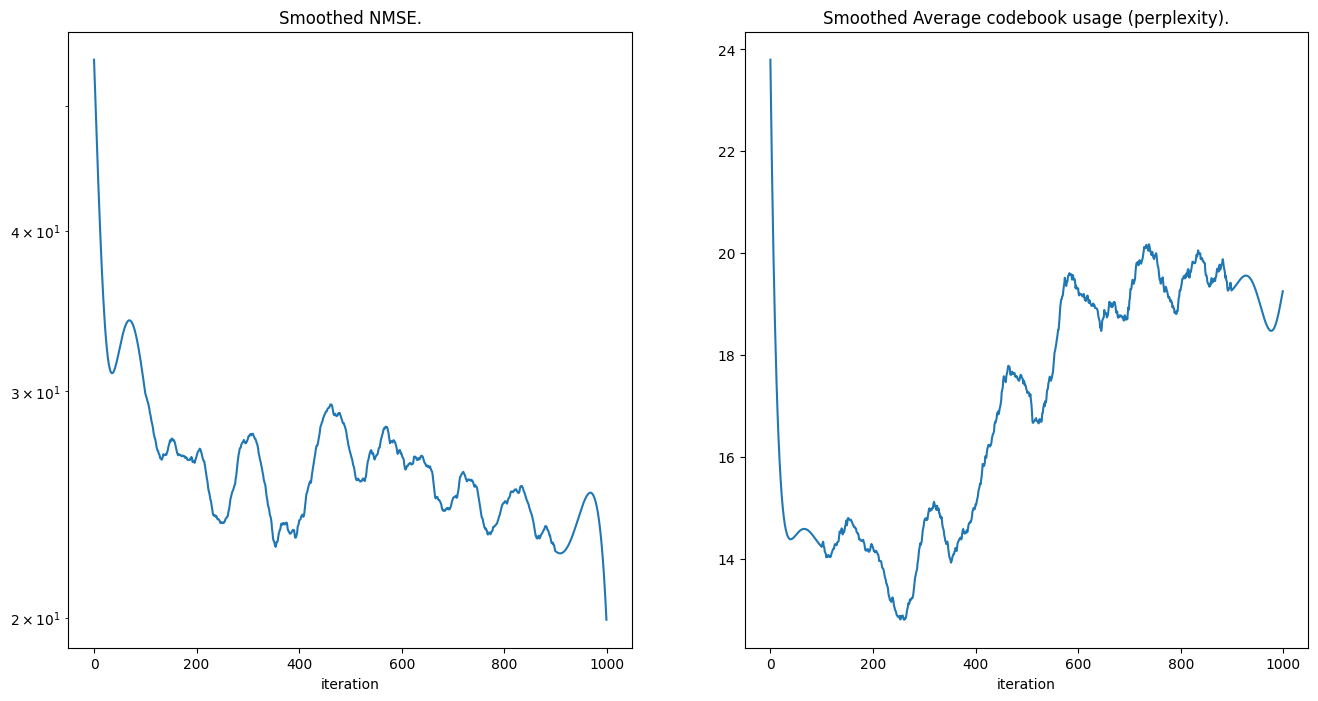

In [105]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_res_recon_error_smooth)
ax.set_yscale('log')
ax.set_title('Smoothed NMSE.')
ax.set_xlabel('iteration')

ax = f.add_subplot(1,2,2)
ax.plot(train_res_perplexity_smooth)
ax.set_title('Smoothed Average codebook usage (perplexity).')
ax.set_xlabel('iteration')

In [110]:
emb_weight = model._vq_vae._embedding.weight.detach().cpu().numpy()

In [111]:
emb_weight

array([[-1.8173363e-05,  8.1241853e-04, -2.6692869e-05, ...,
        -4.5595504e-04, -1.9319453e-03,  8.3352090e-04],
       [ 1.4410920e-03, -9.6053188e-04,  1.4919869e-03, ...,
        -1.5932065e-03,  1.0876171e-03,  6.1642309e-04],
       [-1.6595742e-03, -1.2410628e-03,  1.2870855e-04, ...,
         4.0507852e-04, -1.1565431e-03,  1.3525297e-03],
       ...,
       [ 1.0553545e-03, -1.8055472e-03,  1.3791469e-03, ...,
         1.7436356e-03,  1.0519340e-03,  1.3697916e-04],
       [-1.2815564e-03, -1.9517906e-03, -6.0144369e-04, ...,
         1.1114043e-03, -7.5579924e-04, -1.2559956e-04],
       [-6.5803761e-05,  1.0004400e-03,  1.0588439e-03, ...,
         1.2977035e-03, -9.3225716e-04, -7.9921586e-04]], dtype=float32)

In [112]:
np.save(
    '../audio_embedding.crema_d.npy', emb_weight, allow_pickle=True)

In [113]:
emb_weight.shape

(512, 2046)

In [115]:
print(emb_weight[0])

[-1.8173363e-05  8.1241853e-04 -2.6692869e-05 ... -4.5595504e-04
 -1.9319453e-03  8.3352090e-04]


In [116]:
num_training_updates = 10000
model.train()

for i in range(num_training_updates):
    (data, _) = next(iter(train_loader))
    data = data.to(device)
    optimizer.zero_grad()

    vq_loss, recon_loss, perplexity = model(data)
    loss = vq_loss + recon_loss
    loss.backward()
    optimizer.step()

    train_res_recon_error.append(recon_loss.item())
    train_res_perplexity.append(perplexity.item())

    if (i+1) % log_interval == 0:
        print('%d iterations' % (i+1))
        print('recon_error: %.3f' % np.mean(train_res_recon_error[-log_interval:]))
        print('perplexity: %.3f' % np.mean(train_res_perplexity[-log_interval:]))
        print()

100 iterations
recon_error: 22.011
perplexity: 18.696

200 iterations
recon_error: 22.194
perplexity: 19.615

300 iterations
recon_error: 20.898
perplexity: 19.014

400 iterations
recon_error: 20.760
perplexity: 18.938

500 iterations
recon_error: 20.231
perplexity: 17.835

600 iterations
recon_error: 20.181
perplexity: 18.093

700 iterations
recon_error: 22.861
perplexity: 20.017

800 iterations
recon_error: 22.301
perplexity: 21.370

900 iterations
recon_error: 21.026
perplexity: 21.740

1000 iterations
recon_error: 20.384
perplexity: 20.699

1100 iterations
recon_error: 19.414
perplexity: 18.782

1200 iterations
recon_error: 22.661
perplexity: 21.921

1300 iterations
recon_error: 22.770
perplexity: 23.099

1400 iterations
recon_error: 22.683
perplexity: 23.856

1500 iterations
recon_error: 21.135
perplexity: 22.386

1600 iterations
recon_error: 23.066
perplexity: 25.103

1700 iterations
recon_error: 22.598
perplexity: 25.647

1800 iterations
recon_error: 21.992
perplexity: 24.912

1

In [123]:
train_res_recon_error_smooth = savgol_filter(train_res_recon_error, 301, 7)
train_res_perplexity_smooth = savgol_filter(train_res_perplexity, 301, 7)

Text(0.5, 0, 'iteration')

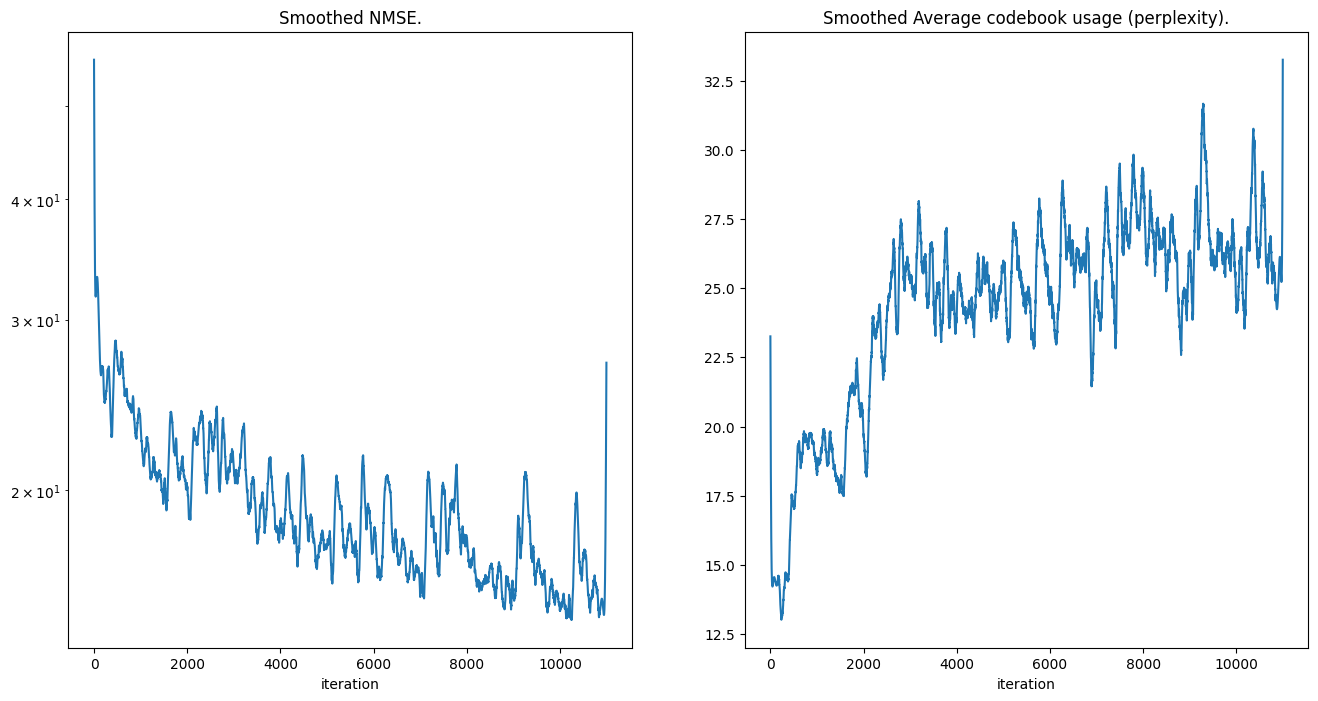

In [124]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_res_recon_error_smooth)
ax.set_yscale('log')
ax.set_title('Smoothed NMSE.')
ax.set_xlabel('iteration')

ax = f.add_subplot(1,2,2)
ax.plot(train_res_perplexity_smooth)
ax.set_title('Smoothed Average codebook usage (perplexity).')
ax.set_xlabel('iteration')

Text(0.5, 0, 'iteration')

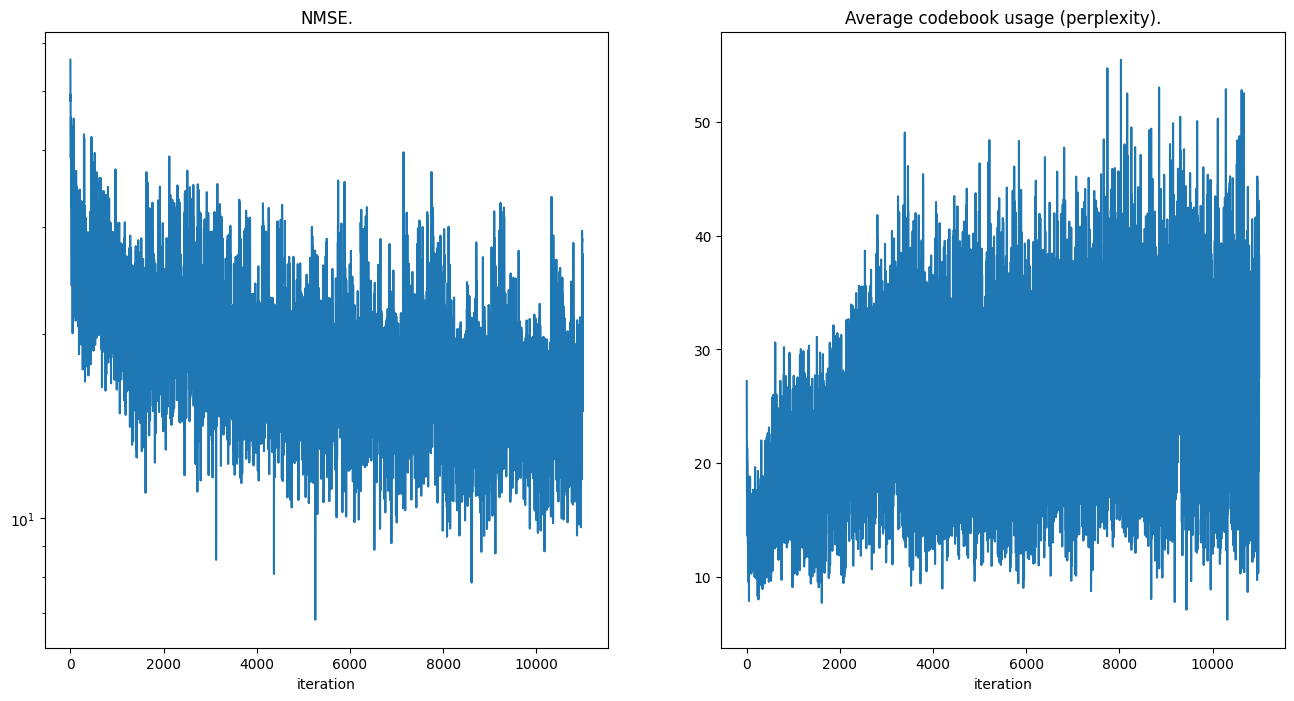

In [125]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_res_recon_error)
ax.set_yscale('log')
ax.set_title('NMSE.')
ax.set_xlabel('iteration')

ax = f.add_subplot(1,2,2)
ax.plot(train_res_perplexity)
ax.set_title('Average codebook usage (perplexity).')
ax.set_xlabel('iteration')

In [126]:
np.save(
    '../audio_embedding.crema_d.step11k.npy', emb_weight, allow_pickle=True)

In [127]:
num_training_updates = 9000
model.train()

for i in range(num_training_updates):
    (data, _) = next(iter(train_loader))
    data = data.to(device)
    optimizer.zero_grad()

    vq_loss, recon_loss, perplexity = model(data)
    loss = vq_loss + recon_loss
    loss.backward()
    optimizer.step()

    train_res_recon_error.append(recon_loss.item())
    train_res_perplexity.append(perplexity.item())

    if (i+1) % log_interval == 0:
        print('%d iterations' % (i+1))
        print('recon_error: %.3f' % np.mean(train_res_recon_error[-log_interval:]))
        print('perplexity: %.3f' % np.mean(train_res_perplexity[-log_interval:]))
        print()

100 iterations
recon_error: 17.439
perplexity: 28.475

200 iterations
recon_error: 20.913
perplexity: 30.189

300 iterations
recon_error: 19.733
perplexity: 30.222

400 iterations
recon_error: 17.325
perplexity: 29.960

500 iterations
recon_error: 17.335
perplexity: 30.231

600 iterations
recon_error: 16.760
perplexity: 30.126

700 iterations
recon_error: 17.980
perplexity: 27.609

800 iterations
recon_error: 16.886
perplexity: 29.514

900 iterations
recon_error: 16.983
perplexity: 29.638

1000 iterations
recon_error: 16.286
perplexity: 28.534

1100 iterations
recon_error: 15.440
perplexity: 28.187

1200 iterations
recon_error: 15.458
perplexity: 27.420

1300 iterations
recon_error: 15.575
perplexity: 26.378

1400 iterations
recon_error: 15.634
perplexity: 26.658

1500 iterations
recon_error: 18.708
perplexity: 28.535

1600 iterations
recon_error: 16.869
perplexity: 28.950

1700 iterations
recon_error: 15.718
perplexity: 26.588

1800 iterations
recon_error: 15.639
perplexity: 27.854

1

In [128]:
np.save(
    '../audio_embedding.crema_d.step20k.npy', emb_weight, allow_pickle=True)

In [129]:
train_res_recon_error_smooth = savgol_filter(train_res_recon_error, 301, 7)
train_res_perplexity_smooth = savgol_filter(train_res_perplexity, 301, 7)

Text(0.5, 0, 'iteration')

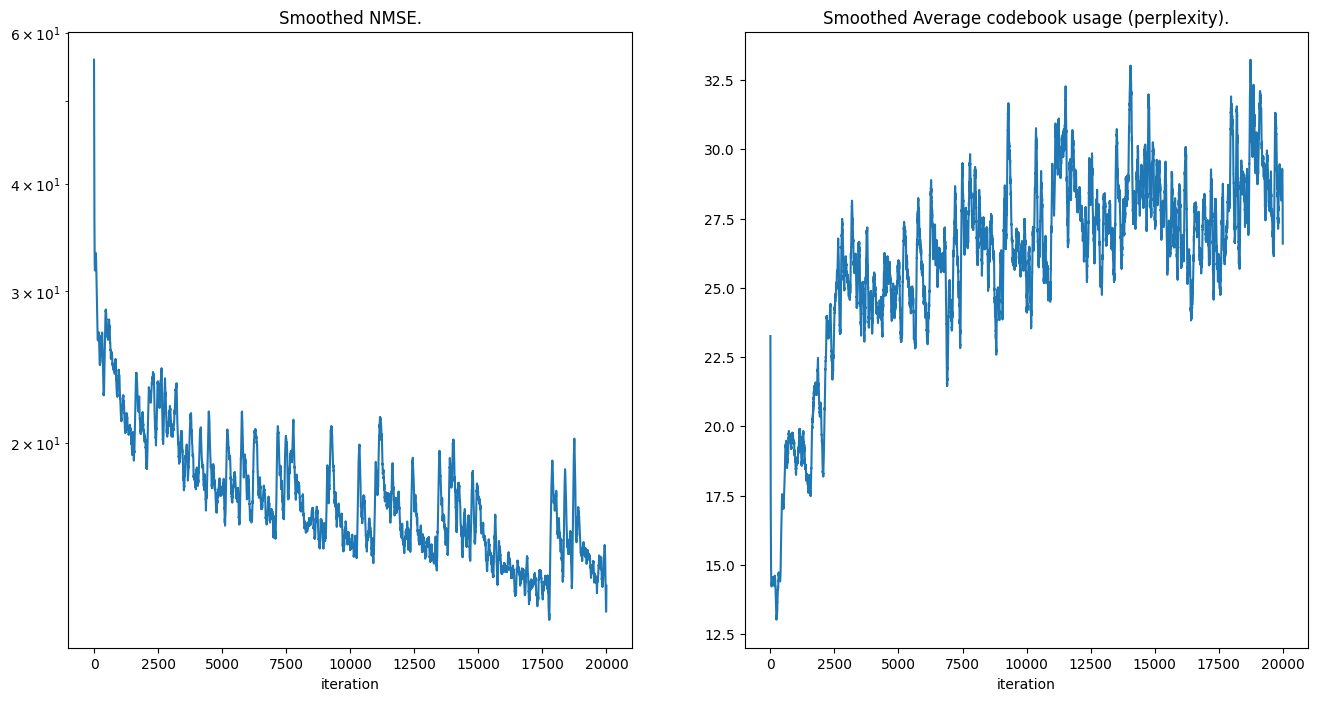

In [130]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_res_recon_error_smooth)
ax.set_yscale('log')
ax.set_title('Smoothed NMSE.')
ax.set_xlabel('iteration')

ax = f.add_subplot(1,2,2)
ax.plot(train_res_perplexity_smooth)
ax.set_title('Smoothed Average codebook usage (perplexity).')
ax.set_xlabel('iteration')

In [131]:
model_path = '../audio_embedding.model.crema_d.step20k.pt'
torch.save(model.state_dict(), model_path)

In [132]:
model_path = '../audio_embedding.vq.crema_d.step20k.pt'
torch.save(model._vq_vae.state_dict(), model_path)

## View Embedding

In [133]:
import umap

In [134]:
proj = umap.UMAP(n_neighbors=3,
                 min_dist=0.1,
                 metric='cosine').fit_transform(model._vq_vae._embedding.weight.data.cpu())

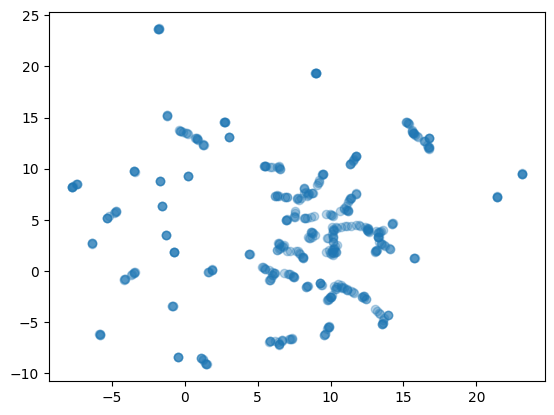

In [135]:
plt.scatter(proj[:,0], proj[:,1], alpha=0.3)

In [138]:
def draw_umap(
    data, 
    n_neighbors=15, min_dist=0.1, 
    n_components=2, metric='euclidean', title=''):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(data);
    fig = plt.figure()
    if n_components == 1:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], range(len(u)))
    if n_components == 2:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], u[:,1])
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(u[:,0], u[:,1], u[:,2], s=100)
    plt.title(title, fontsize=18)

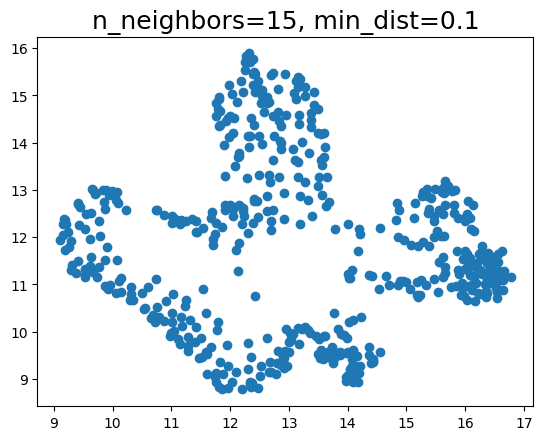

In [139]:
emb_data = model._vq_vae._embedding.weight.data.cpu()
k = 15
min_dist=0.1
draw_umap(emb_data, n_neighbors=k, min_dist=min_dist, metric='euclidean', 
          title=f'n_neighbors={k}, min_dist={min_dist}')

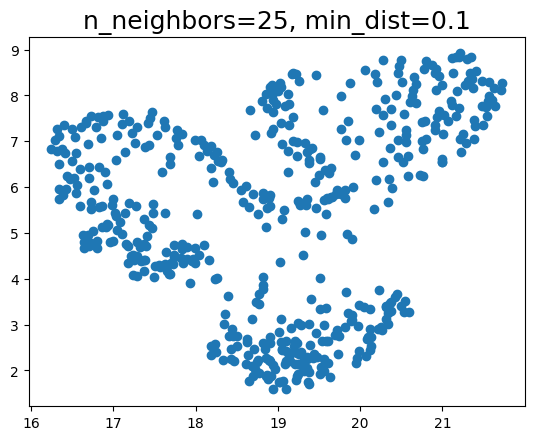

In [140]:
k = 25
min_dist=0.1
draw_umap(emb_data, n_neighbors=k, min_dist=min_dist, metric='euclidean', 
          title=f'n_neighbors={k}, min_dist={min_dist}')

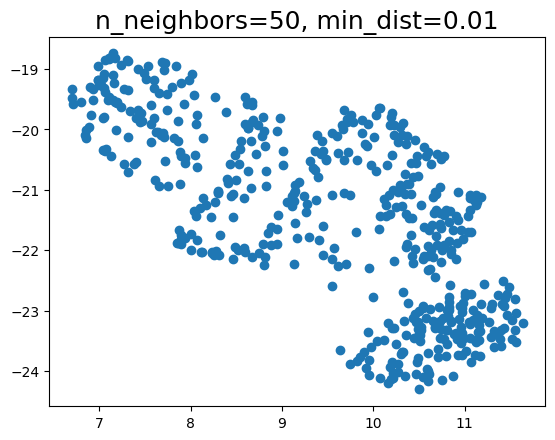

In [145]:
k = 50
min_dist=0.01
draw_umap(emb_data, n_neighbors=k, min_dist=min_dist, metric='euclidean', 
          title=f'n_neighbors={k}, min_dist={min_dist}')

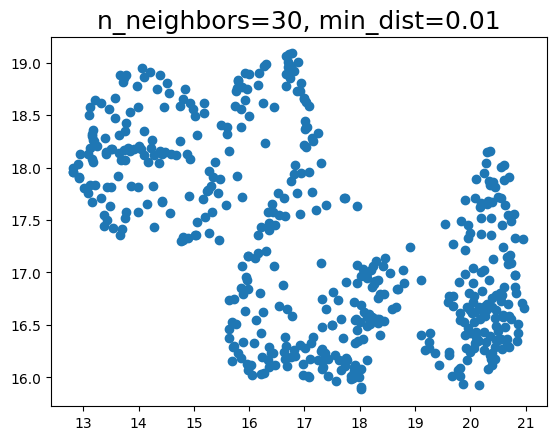

In [146]:
k = 30
min_dist=0.01
draw_umap(emb_data, n_neighbors=k, min_dist=min_dist, metric='euclidean', 
          title=f'n_neighbors={k}, min_dist={min_dist}')

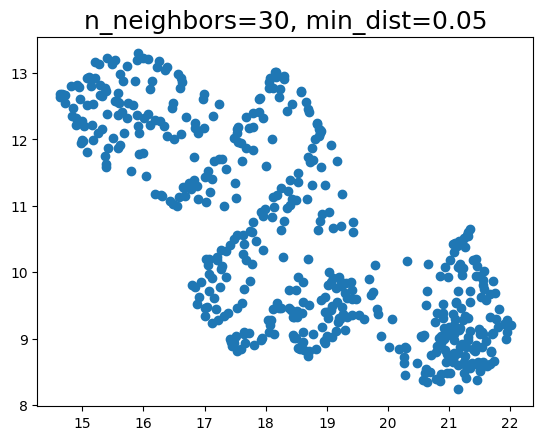

In [147]:
k = 30
min_dist=0.05
draw_umap(emb_data, n_neighbors=k, min_dist=min_dist, metric='euclidean', 
          title=f'n_neighbors={k}, min_dist={min_dist}')

In [148]:
previous_iter = 20000
num_training_updates = 20000
model.train()

for i in range(num_training_updates):
    (data, _) = next(iter(train_loader))
    data = data.to(device)
    optimizer.zero_grad()

    vq_loss, recon_loss, perplexity = model(data)
    loss = vq_loss + recon_loss
    loss.backward()
    optimizer.step()

    train_res_recon_error.append(recon_loss.item())
    train_res_perplexity.append(perplexity.item())

    if (i+1) % log_interval == 0:
        print('%d iterations' % (i+previous_iter+1))
        print('recon_error: %.3f' % np.mean(train_res_recon_error[-log_interval:]))
        print('perplexity: %.3f' % np.mean(train_res_perplexity[-log_interval:]))
        print()

20100 iterations
recon_error: 14.185
perplexity: 27.830

20200 iterations
recon_error: 13.523
perplexity: 26.832

20300 iterations
recon_error: 13.867
perplexity: 26.323

20400 iterations
recon_error: 13.590
perplexity: 26.440

20500 iterations
recon_error: 13.513
perplexity: 26.988

20600 iterations
recon_error: 16.534
perplexity: 29.747

20700 iterations
recon_error: 14.799
perplexity: 28.145

20800 iterations
recon_error: 14.451
perplexity: 27.028

20900 iterations
recon_error: 14.097
perplexity: 28.021

21000 iterations
recon_error: 14.707
perplexity: 28.366

21100 iterations
recon_error: 18.072
perplexity: 29.853

21200 iterations
recon_error: 18.482
perplexity: 31.819

21300 iterations
recon_error: 18.095
perplexity: 31.779

21400 iterations
recon_error: 14.727
perplexity: 31.562

21500 iterations
recon_error: 14.618
perplexity: 29.499

21600 iterations
recon_error: 13.407
perplexity: 28.165

21700 iterations
recon_error: 14.488
perplexity: 28.841

21800 iterations
recon_error: 1

In [150]:
np.save(
    '../audio_embedding.crema_d.step40k.npy', emb_weight, allow_pickle=True)

In [151]:
model_path = '../audio_embedding.vq.crema_d.step40k.pt'
torch.save(model._vq_vae.state_dict(), model_path)

In [152]:
train_res_recon_error_smooth = savgol_filter(train_res_recon_error, 301, 7)
train_res_perplexity_smooth = savgol_filter(train_res_perplexity, 301, 7)

In [239]:
np.save(
    '../train_res_recon_error_smooth.crema_d.step40k.npy', 
    train_res_recon_error_smooth, allow_pickle=True)

In [240]:
np.save(
    '../train_res_perplexity_smooth.crema_d.step40k.npy', 
    train_res_perplexity_smooth, allow_pickle=True)

In [241]:
np.save(
    '../train_res_recon_error.crema_d.step40k.npy', 
    train_res_recon_error, allow_pickle=True)
np.save(
    '../train_res_perplexity.crema_d.step40k.npy', 
    train_res_perplexity, allow_pickle=True)

Text(0.5, 0, 'iteration')

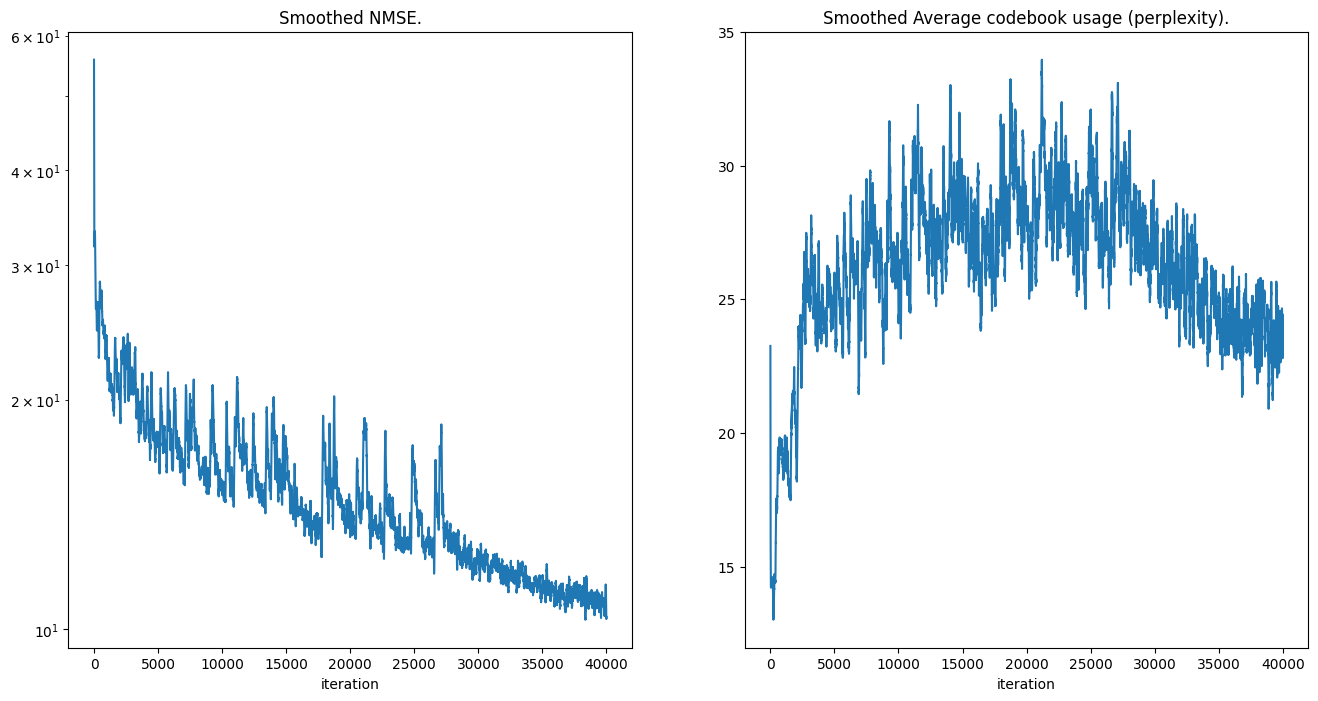

In [153]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_res_recon_error_smooth)
ax.set_yscale('log')
ax.set_title('Smoothed NMSE.')
ax.set_xlabel('iteration')

ax = f.add_subplot(1,2,2)
ax.plot(train_res_perplexity_smooth)
ax.set_title('Smoothed Average codebook usage (perplexity).')
ax.set_xlabel('iteration')

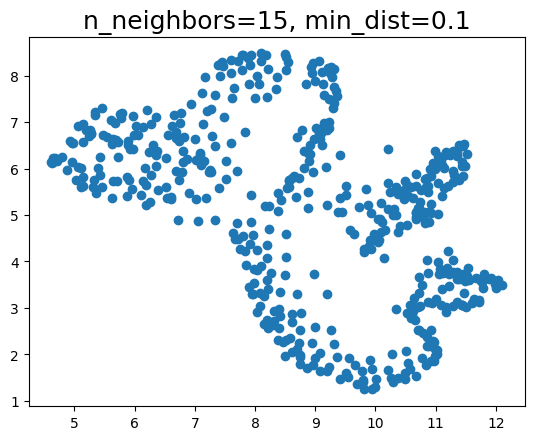

In [154]:
emb_data2 = model._vq_vae._embedding.weight.data.cpu()
k = 15
min_dist=0.1
draw_umap(emb_data2, n_neighbors=k, min_dist=min_dist, metric='euclidean', 
          title=f'n_neighbors={k}, min_dist={min_dist}')

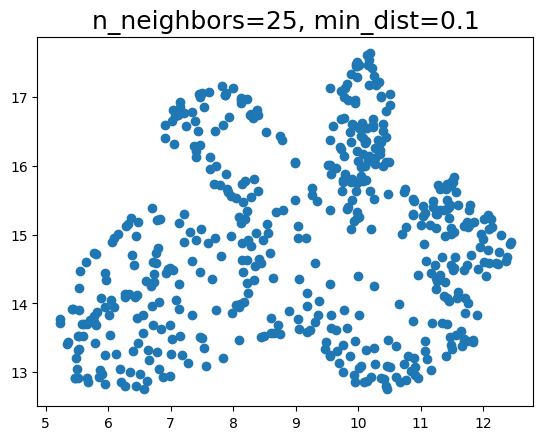

In [155]:
k = 25
min_dist=0.1
draw_umap(emb_data2, n_neighbors=k, min_dist=min_dist, metric='euclidean', 
          title=f'n_neighbors={k}, min_dist={min_dist}')

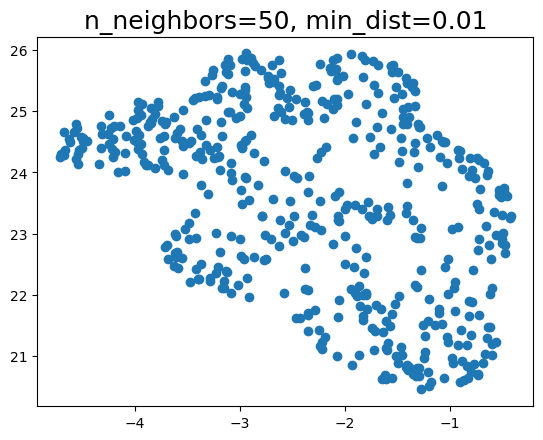

In [156]:
k = 50
min_dist=0.01
draw_umap(emb_data2, n_neighbors=k, min_dist=min_dist, metric='euclidean', 
          title=f'n_neighbors={k}, min_dist={min_dist}')

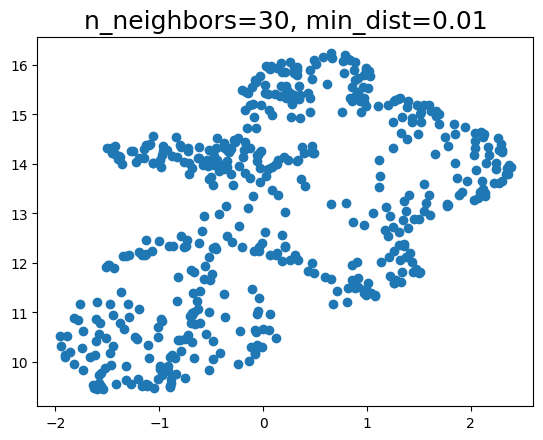

In [157]:
k = 30
min_dist=0.01
draw_umap(emb_data2, n_neighbors=k, min_dist=min_dist, metric='euclidean', 
          title=f'n_neighbors={k}, min_dist={min_dist}')

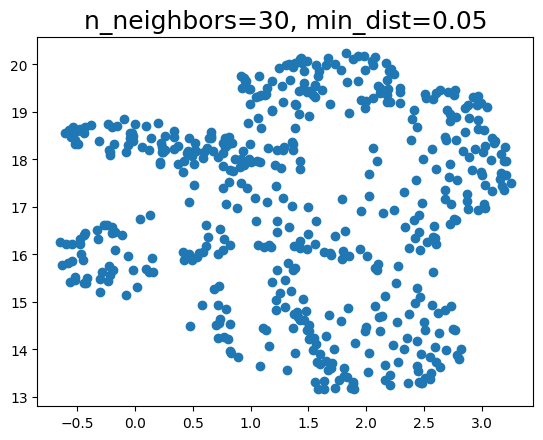

In [158]:
k = 30
min_dist=0.05
draw_umap(emb_data2, n_neighbors=k, min_dist=min_dist, metric='euclidean', 
          title=f'n_neighbors={k}, min_dist={min_dist}')

In [159]:
emb_data2.shape

torch.Size([512, 2046])

In [160]:
import librosa

In [163]:
def get_colors(data):
    out = []
    for y in data:
        zcr = librosa.zero_crossings(y).mean()
        sig = y[y > 0]
        m = sig.mean()
        s = sig.std()
        out += [[zcr,m,s]]
    return np.array(out)

In [164]:
colors = get_colors(emb_data2)
print(colors.shape)
colors

(512, 3)


array([[0.0542522 , 0.33818063, 0.5270561 ],
       [0.70185728, 0.07870844, 0.13483469],
       [0.12072336, 0.11237016, 0.24976274],
       ...,
       [0.05327468, 0.60650426, 0.91380215],
       [0.04887586, 0.16838613, 0.25686657],
       [0.39100684, 0.09252118, 0.15815254]])

In [170]:
np.min(colors)

0.0006684240070171654

In [173]:
max_colors = np.max(colors, axis=0)
max_colors

array([0.86608016, 6.08141708, 8.01816559])

In [174]:
min_colors = np.min(colors, axis=0)
min_colors

array([0.0083089 , 0.00066842, 0.00167097])

In [175]:
colors_norm = np.empty_like(colors)

In [177]:
for i in range(3):
    for j in range(len(colors)):
        x = colors[j][i]
        min_x = min_colors[i]
        max_x = max_colors[i]
        colors_norm[j][i] = (x-min_x)/ (max_x-min_x)

In [178]:
np.max(colors_norm, axis=0)

array([1., 1., 1.])

In [179]:
np.min(colors_norm, axis=0)

array([0., 0., 0.])

In [201]:
def draw_umap2(
    data, colors, edgecolors="black",
    n_neighbors=15, min_dist=0.1, 
    n_components=2, metric='euclidean', title=''):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(data)
    fig = plt.figure()
    if n_components == 1:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], range(len(u)), c=colors, edgecolors= edgecolors)
    if n_components == 2:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], u[:,1], c=colors, edgecolors=edgecolors)
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(u[:,0], u[:,1], u[:,2], s=100, c=colors, edgecolors=edgecolors)
    plt.title(title, fontsize=18)

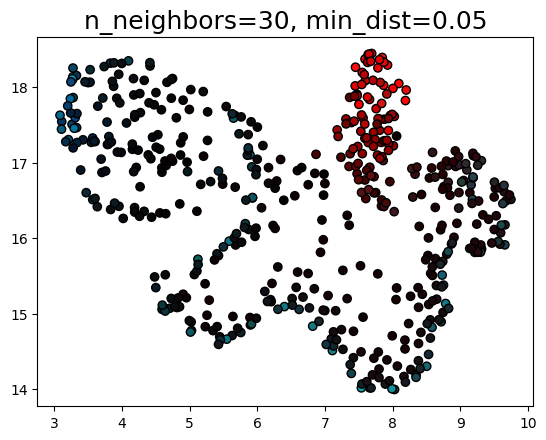

In [190]:
k = 30
min_dist=0.05
draw_umap2(emb_data2, colors=colors_norm,
           n_neighbors=k, min_dist=min_dist, metric='euclidean', 
          title=f'n_neighbors={k}, min_dist={min_dist}')

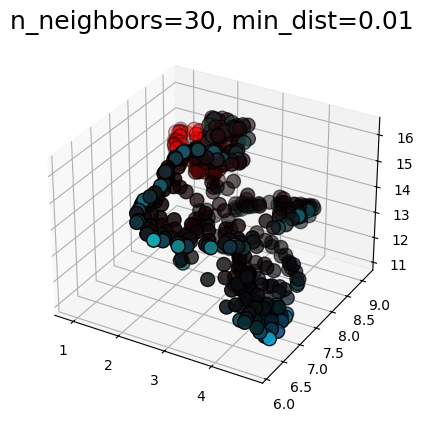

In [191]:
k = 30
min_dist=0.01
draw_umap2(emb_data2, colors=colors_norm,
           n_neighbors=k, min_dist=min_dist, 
           metric='euclidean', n_components=3,
          title=f'n_neighbors={k}, min_dist={min_dist}')

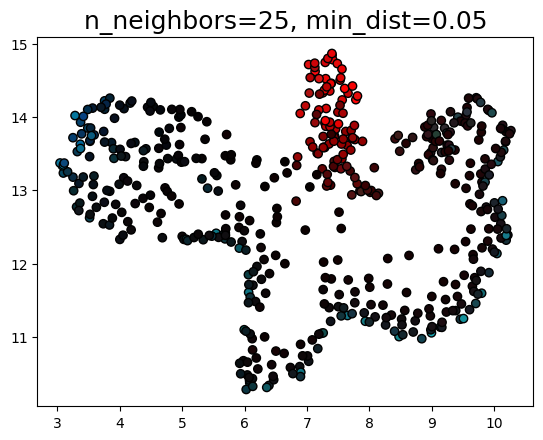

In [192]:
k = 25
min_dist=0.05
draw_umap2(emb_data2, colors=colors_norm,
           n_neighbors=k, min_dist=min_dist, metric='euclidean', 
          title=f'n_neighbors={k}, min_dist={min_dist}')

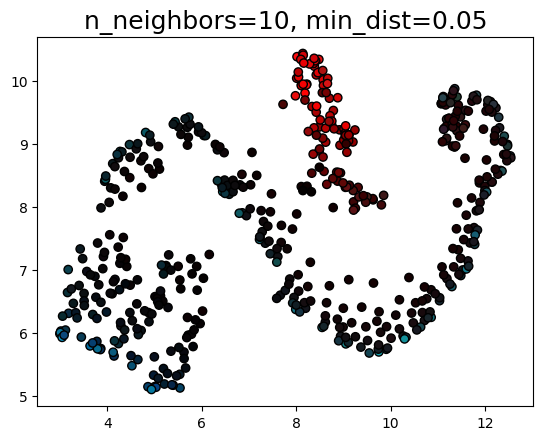

In [193]:
k = 10
min_dist=0.05
draw_umap2(emb_data2, colors=colors_norm,
           n_neighbors=k, min_dist=min_dist, metric='euclidean', 
          title=f'n_neighbors={k}, min_dist={min_dist}')

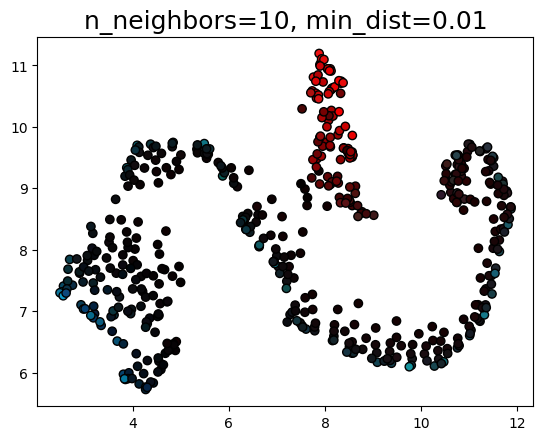

In [194]:
k = 10
min_dist=0.01
draw_umap2(emb_data2, colors=colors_norm,
           n_neighbors=k, min_dist=min_dist, metric='euclidean', 
          title=f'n_neighbors={k}, min_dist={min_dist}')

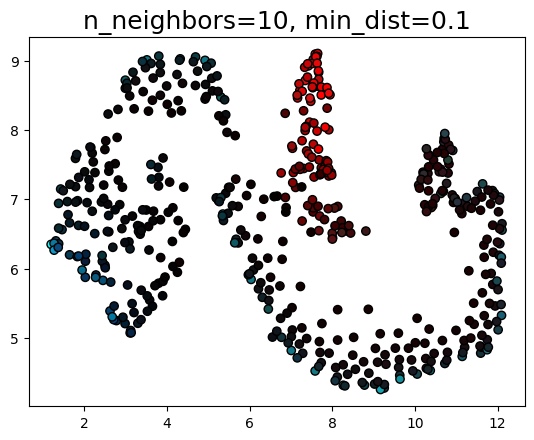

In [195]:
k = 10
min_dist=0.1
draw_umap2(emb_data2, colors=colors_norm,
           n_neighbors=k, min_dist=min_dist, metric='euclidean', 
          title=f'n_neighbors={k}, min_dist={min_dist}')

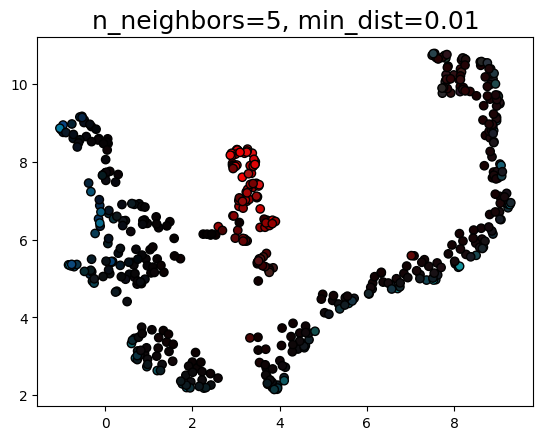

In [196]:
k = 5
min_dist=0.01
draw_umap2(emb_data2, colors=colors_norm,
           n_neighbors=k, min_dist=min_dist, metric='euclidean', 
          title=f'n_neighbors={k}, min_dist={min_dist}')

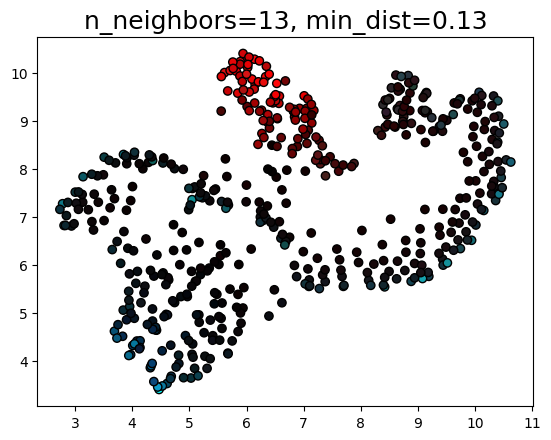

In [198]:
k = 13
min_dist=0.13
draw_umap2(emb_data2, colors=colors_norm,
           n_neighbors=k, min_dist=min_dist, metric='euclidean', 
          title=f'n_neighbors={k}, min_dist={min_dist}')

In [199]:
colors_sig = F.sigmoid(torch.tensor(colors)).numpy()
colors_sig

array([[0.51355972, 0.58374851, 0.62879623],
       [0.66859943, 0.51966696, 0.5336577 ],
       [0.53014424, 0.52806302, 0.5621181 ],
       ...,
       [0.51331552, 0.64714297, 0.71377757],
       [0.51221653, 0.54199735, 0.56386587],
       [0.59652505, 0.52311381, 0.53945593]])

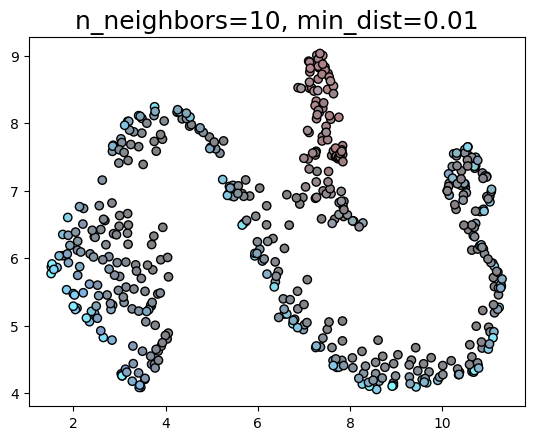

In [200]:
k = 10
min_dist=0.01
draw_umap2(emb_data2, colors=colors_sig,
           n_neighbors=k, min_dist=min_dist, metric='euclidean', 
          title=f'n_neighbors={k}, min_dist={min_dist}')

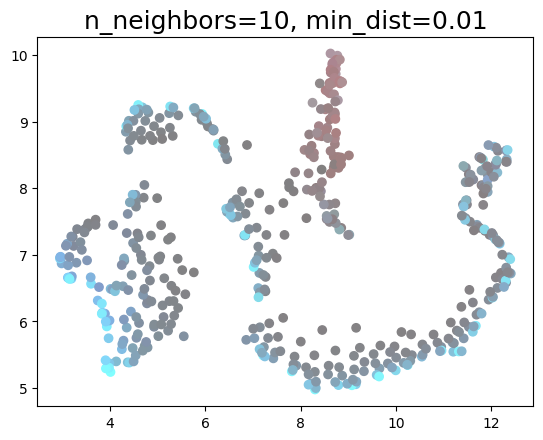

In [202]:
k = 10
min_dist=0.01
draw_umap2(emb_data2, colors=colors_sig, edgecolors=None,
           n_neighbors=k, min_dist=min_dist, metric='euclidean', 
          title=f'n_neighbors={k}, min_dist={min_dist}')

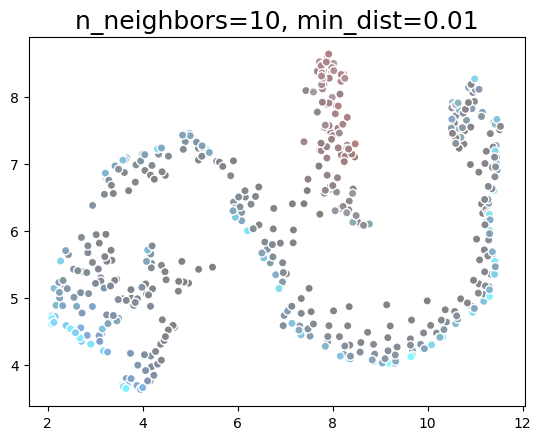

In [203]:
k = 10
min_dist=0.01
draw_umap2(emb_data2, colors=colors_sig, edgecolors="white",
           n_neighbors=k, min_dist=min_dist, metric='euclidean', 
          title=f'n_neighbors={k}, min_dist={min_dist}')

In [204]:
import matplotlib.pyplot as plt
import pandas as pd
import math
import seaborn as sns
sns.set_theme(style="dark")

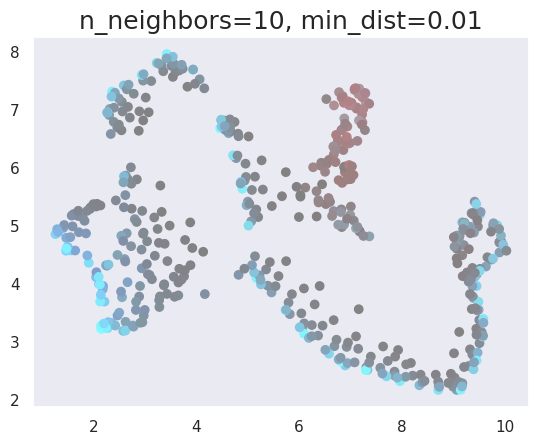

In [206]:
k = 10
min_dist=0.01
draw_umap2(emb_data2, colors=colors_sig, edgecolors=None,
           n_neighbors=k, min_dist=min_dist, metric='euclidean', 
          title=f'n_neighbors={k}, min_dist={min_dist}')

In [207]:
from librosa import display

In [238]:
from scipy.io import wavfile
import scipy
import scipy.fft

fmin=librosa.note_to_hz('C2') #recommended for pyin
fmax=librosa.note_to_hz('C7')

class Audio:
    def __init__(self, filename="", y=sr, sr=sr, title="", file_dir="./"):
        self.win_length = 256
        self.hop_length = self.win_length // 4
        self.n_mfcc = 128
        self.n_mels = 128
        
        if filename:
            y, sr = librosa.load(file_dir + filename, sr=sr)
            if y.ndim > 1: # convert stereo to mono
                y = y[:,1]
        self.y = y
        self.sr = sr
        self.n_samples = len(y)
        self.duration = self.n_samples / self.sr
        self.time_vector = np.linspace(0, self.duration, self.n_samples) 

        if title:
            self.title = title
        else:
            self.title = filename   
    
    def get_player(self):
        self.player = ipd.Audio(self.y, rate=self.sr)
        return self.player
    
    def get_f0(self):
        self.f0, voiced_flag, voiced_probs = librosa.pyin(self.y, sr=self.sr,
                                                          fmin=fmin, fmax=fmax,
                                                          win_length=self.win_length, 
            hop_length=self.hop_length)
        return self.f0
    
    def get_chromagram(self):
        self.chromagram = librosa.feature.chroma_cens(C=self.cqt, sr=self.sr,
                                                     bins_per_octave=12)
        return self.chromagram
    
    def extract_features(self):
        # self.get_player()
        self.get_f0()
        self.get_spectrogram()
        self.get_melspectrogram()
        # self.get_mfcc()
        # self.get_cqt()
        # self.get_chromagram()
        # print("extracted: f0, spectrogram, melspectrogram, mfcc, cqt, chromagram")
        
    def show_spectrogram(self, spectrogram, convert_db=True, 
                         y_axis='log', ax=None, fig=None, title="", colorbar=False):
        if not ax:
            fig, ax = plt.subplots(ncols=1, figsize=(6, 4))
        if convert_db:
            spectrogram = librosa.amplitude_to_db(spectrogram, ref=np.max)
        img = display.specshow(spectrogram, sr=self.sr, y_axis=y_axis, x_axis='time', ax=ax)
        ax.set_title(title)
        if colorbar:
            fig.colorbar(img, ax=ax, format="%+2.0f")
        return img

class AudioLibrosa(Audio):
    def __init__(self, filename="", y=sr, sr="", title="", file_dir="./"):
        super().__init__(filename, y, sr, title, file_dir)

    def get_spectrogram(self):
        self.spectrogram = np.abs(librosa.stft(
            y=self.y,
            n_fft=self.win_length, 
            hop_length=self.hop_length))
        return self.spectrogram

    def get_melspectrogram(self):
        self.melspectrogram = librosa.feature.melspectrogram(
            S=self.spectrogram**2, sr=self.sr,
            n_fft=self.win_length, 
            hop_length=self.hop_length,
        n_mels = self.n_mels)
        return self.melspectrogram

    def get_mfcc(self):
        S = librosa.power_to_db(self.melspectrogram)
        self.mfcc = librosa.feature.mfcc(S=S, sr=self.sr, n_mfcc=self.n_mfcc,
                                        n_fft=self.win_length, 
            hop_length=self.hop_length)
        return self.mfcc

    def get_cqt(self):
        self.cqt = librosa.hybrid_cqt(y=self.y, sr=self.sr, bins_per_octave=12,
                                     n_fft=self.win_length, 
            hop_length=self.hop_length) #hybrid_cqt
        return self.cqt

In [224]:
sr

16000

In [244]:
from matplotlib import ticker

In [248]:
def show_feature(waves, colors="blue", title="", expand=False, n=16):
    print(title)
    if expand:
        ncols = 4
        fig, ax = plt.subplots(ncols=ncols, nrows=n//ncols, figsize=(8*ncols, 5*n//ncols))
    else:
        ncols = 8
        fig, ax = plt.subplots(ncols=ncols, nrows=n//ncols, figsize=(6*ncols, 5*n//ncols))
    axi = ax.ravel()    
    i = 0
    for x, y in enumerate(waves[:n//2]):
        if type(colors) == str:
            color = colors
        else:
            color = colors[x]
        audio = AudioLibrosa(y=y, sr=sr, title=f"Embedding {x}")
        audio.extract_features()
        
        img = display.waveshow(audio.y, sr=sr, ax=axi[i], color=color)
        axi[i].set(title=audio.title)
        axi[i].set(xlabel=None)
        axi[i].xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2f}"))
    
        i += 1
        mel_db = librosa.power_to_db(audio.melspectrogram, ref=np.max)
        audio.show_spectrogram(mel_db, convert_db=False, y_axis='mel', ax=axi[i], fig=fig, 
                               title='Melspectrogram & F0', colorbar=expand)  
        times = librosa.times_like(audio.f0, sr=audio.sr)
        axi[i].plot(times, audio.f0, label='F0', color='cyan', linewidth=4)
        axi[i].legend(loc='upper right')
        axi[i].set(xlabel=None)
        axi[i].xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2f}"))
        i += 1
    axi[i-1].set(xlabel="Time")


extracted: f0, spectrogram, melspectrogram, mfcc, cqt, chromagram
extracted: f0, spectrogram, melspectrogram, mfcc, cqt, chromagram
extracted: f0, spectrogram, melspectrogram, mfcc, cqt, chromagram
extracted: f0, spectrogram, melspectrogram, mfcc, cqt, chromagram
extracted: f0, spectrogram, melspectrogram, mfcc, cqt, chromagram
extracted: f0, spectrogram, melspectrogram, mfcc, cqt, chromagram
extracted: f0, spectrogram, melspectrogram, mfcc, cqt, chromagram
extracted: f0, spectrogram, melspectrogram, mfcc, cqt, chromagram


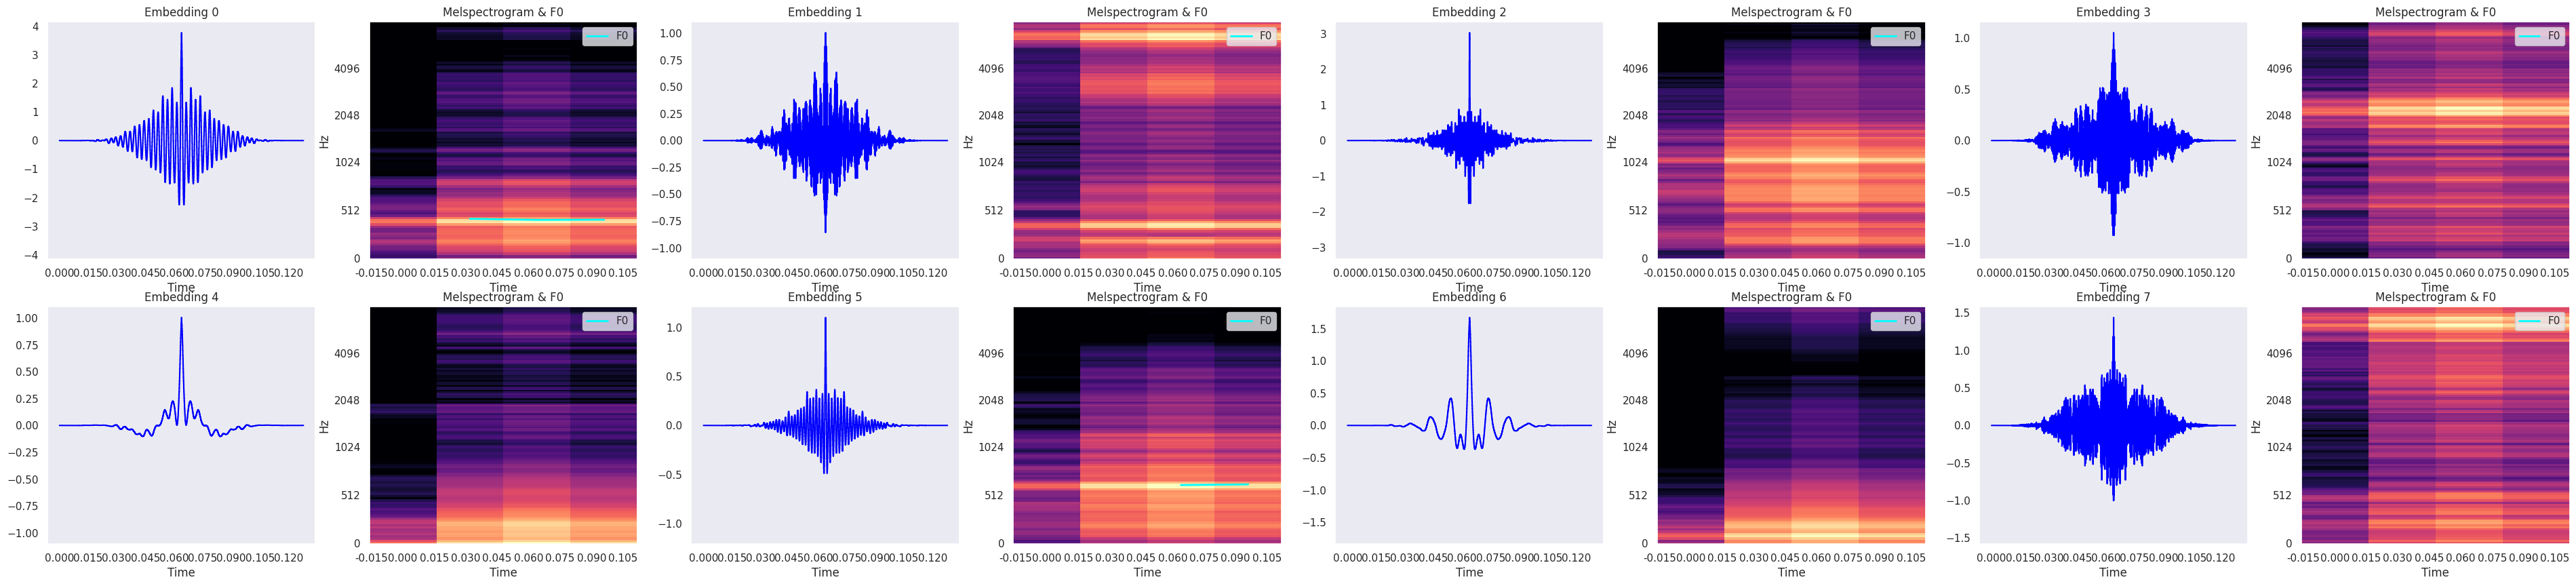

In [228]:
show_feature(emb_data2.numpy())

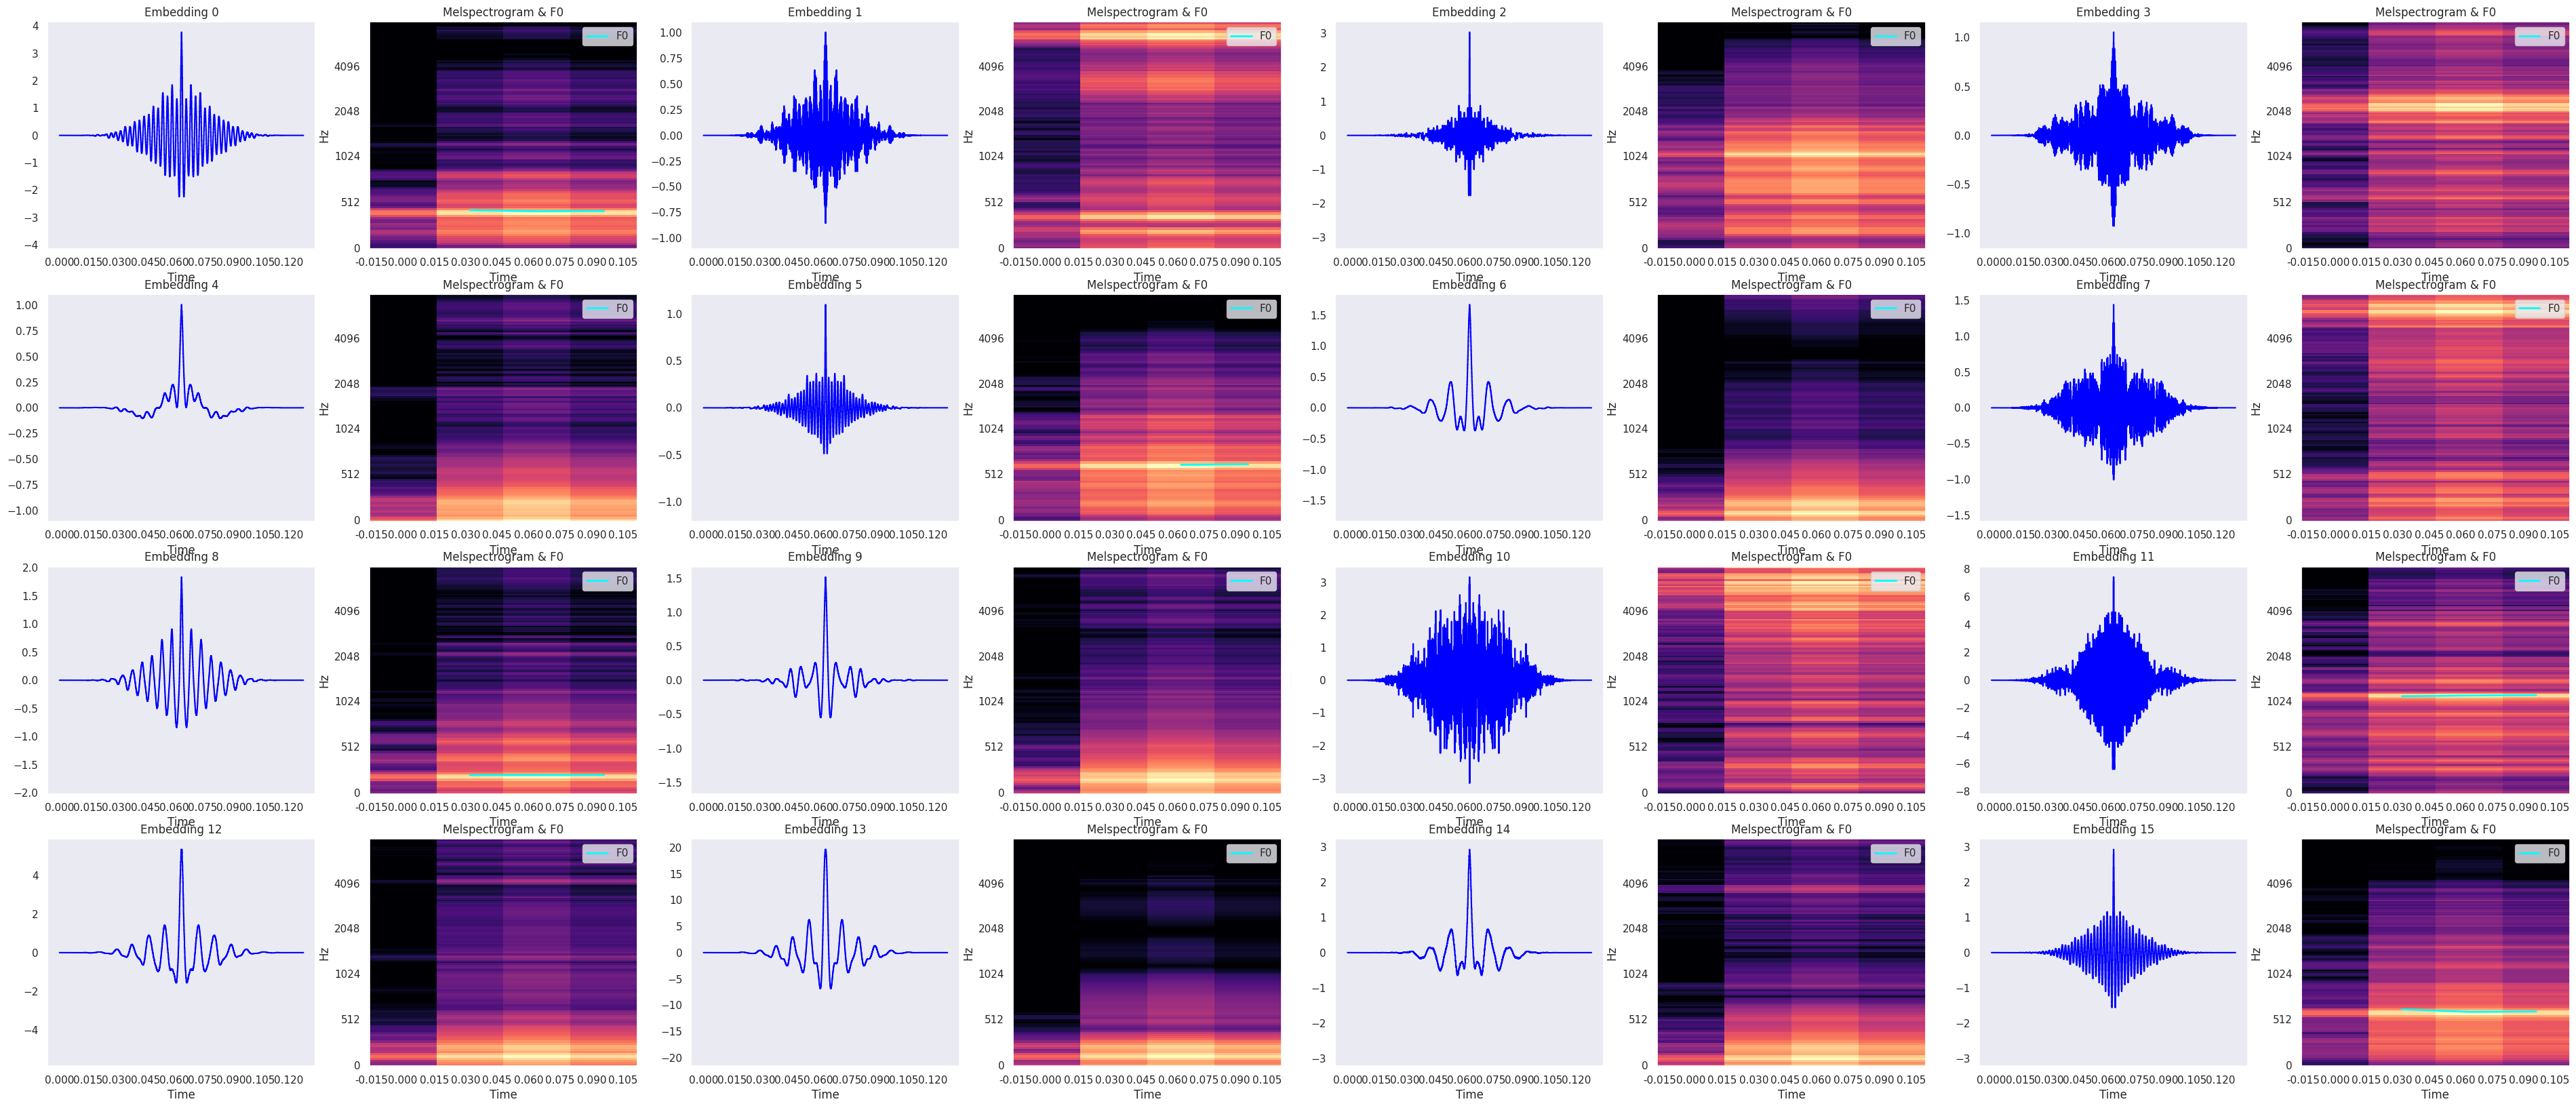

In [230]:
show_feature(emb_data2.numpy(), n=32)

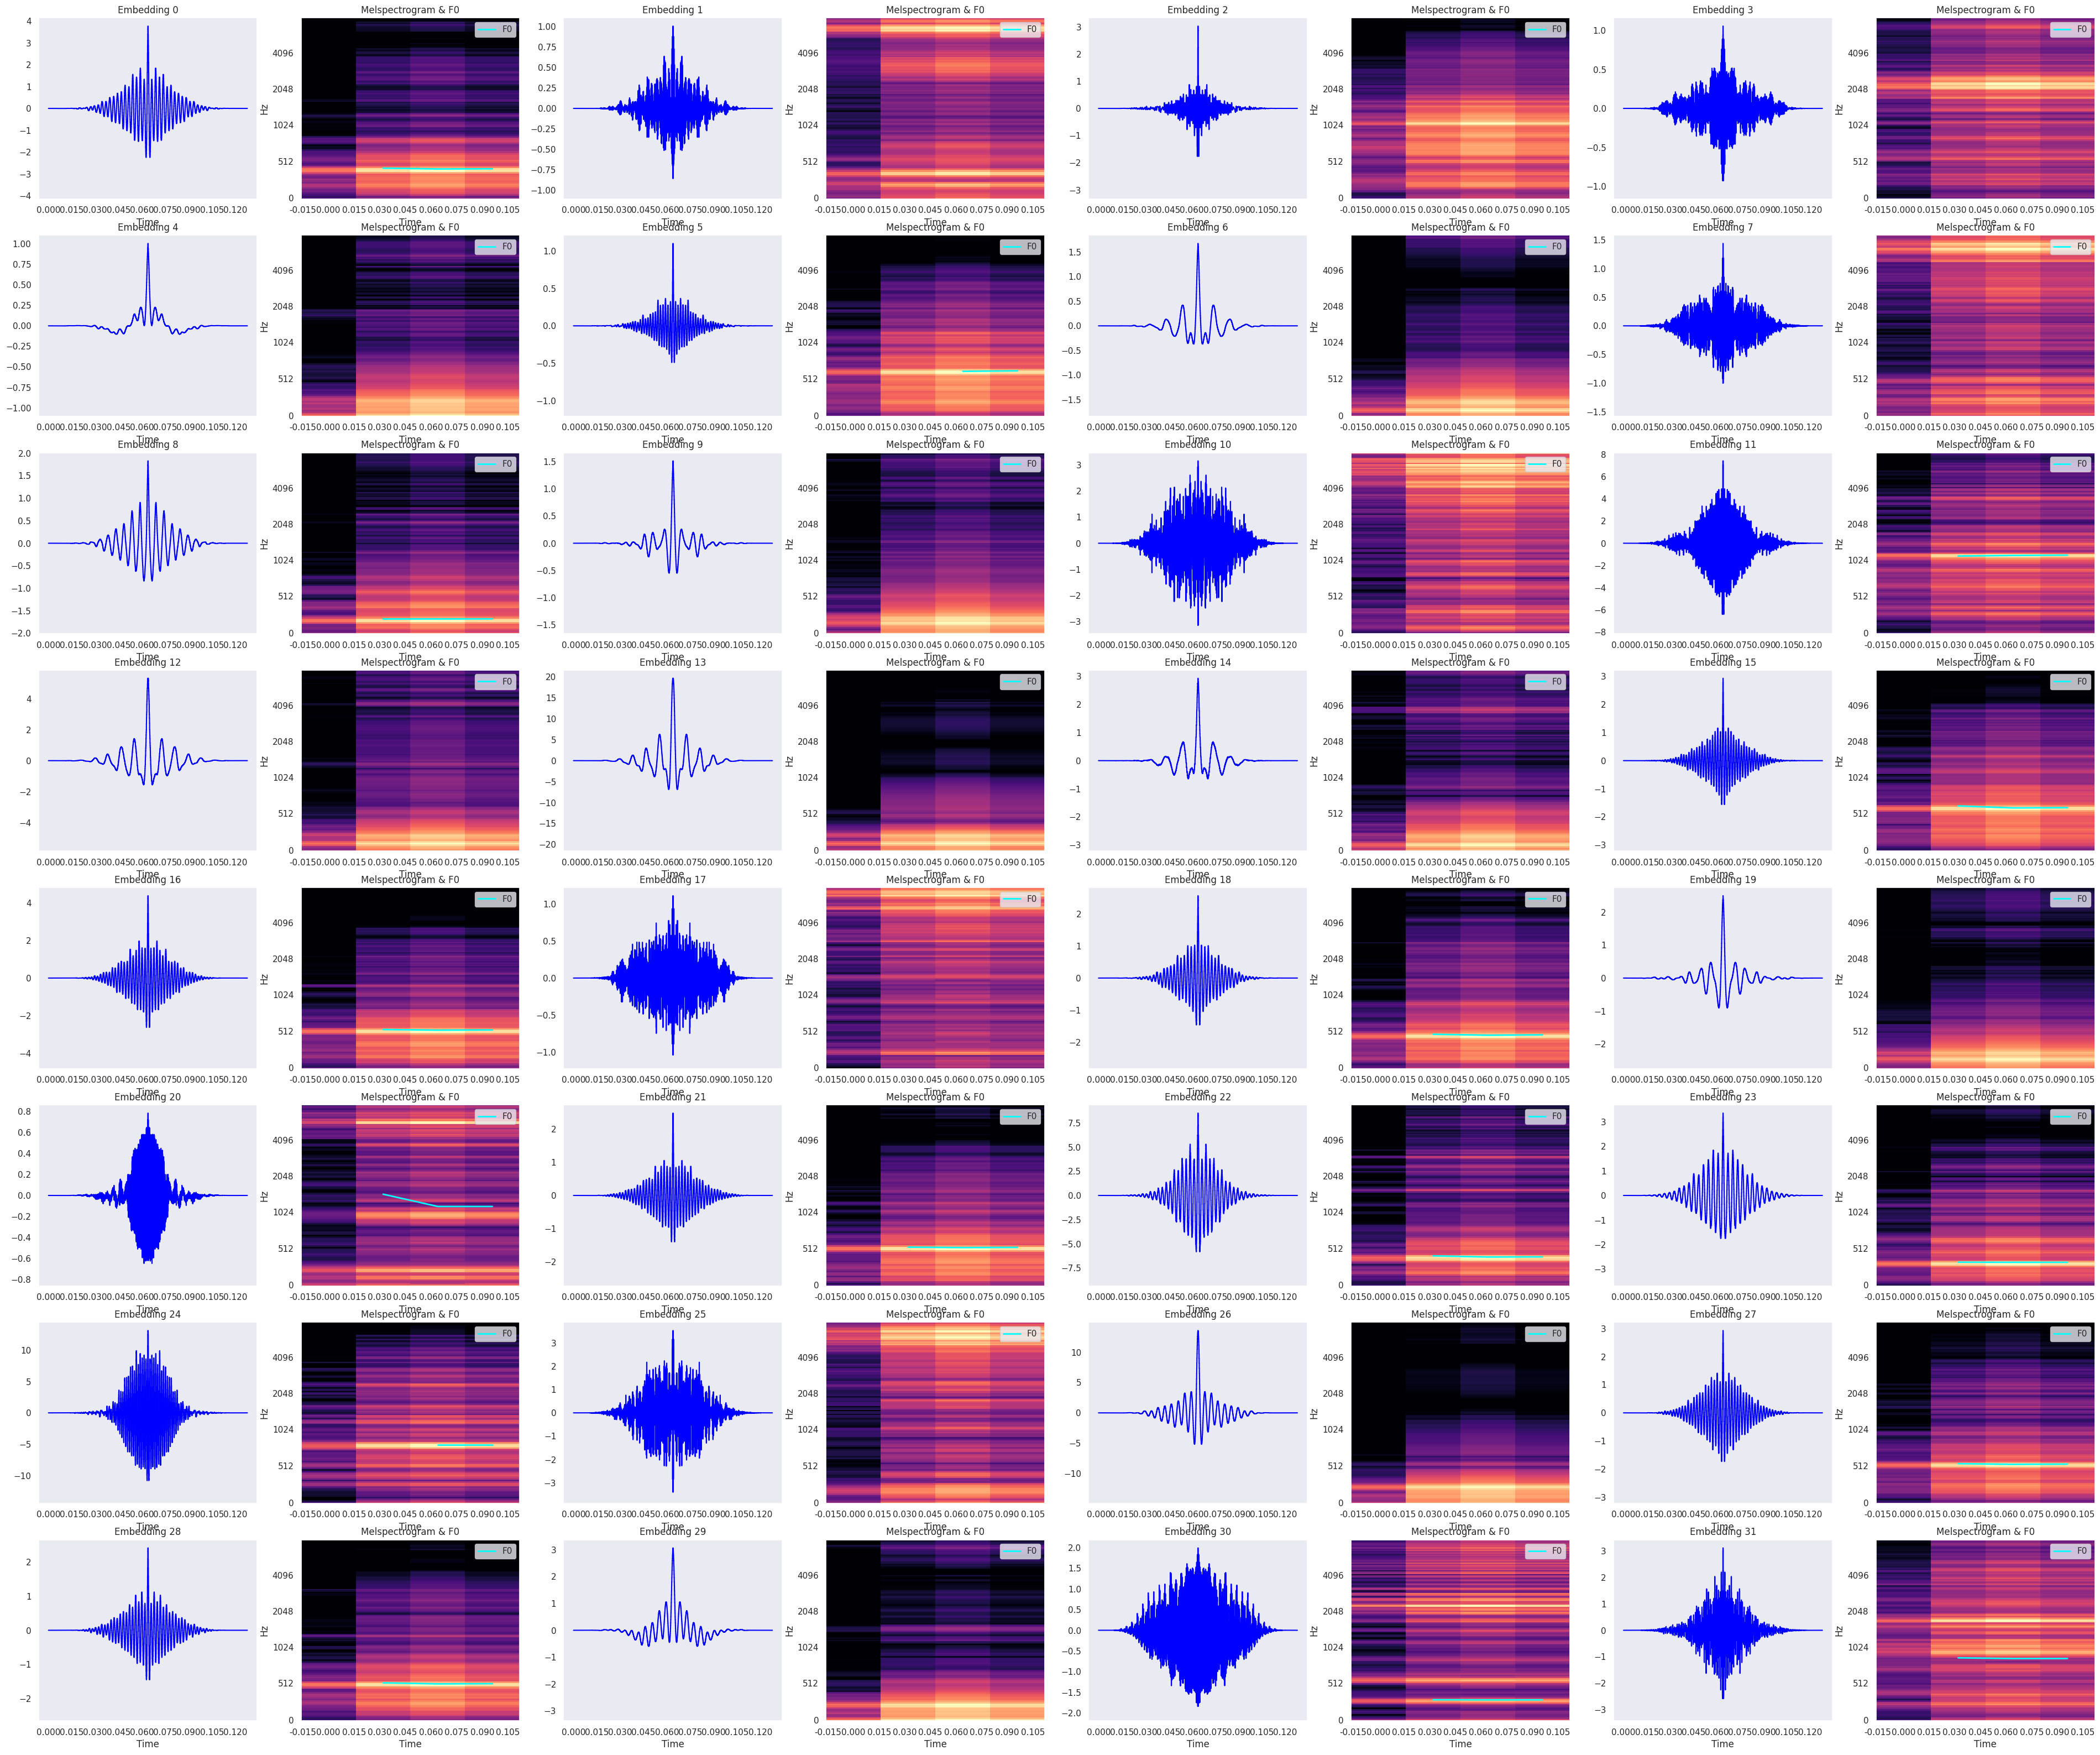

In [231]:
show_feature(emb_data2.numpy(), n=64)

/opt/anaconda3/envs/audio/lib/python3.9/site-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


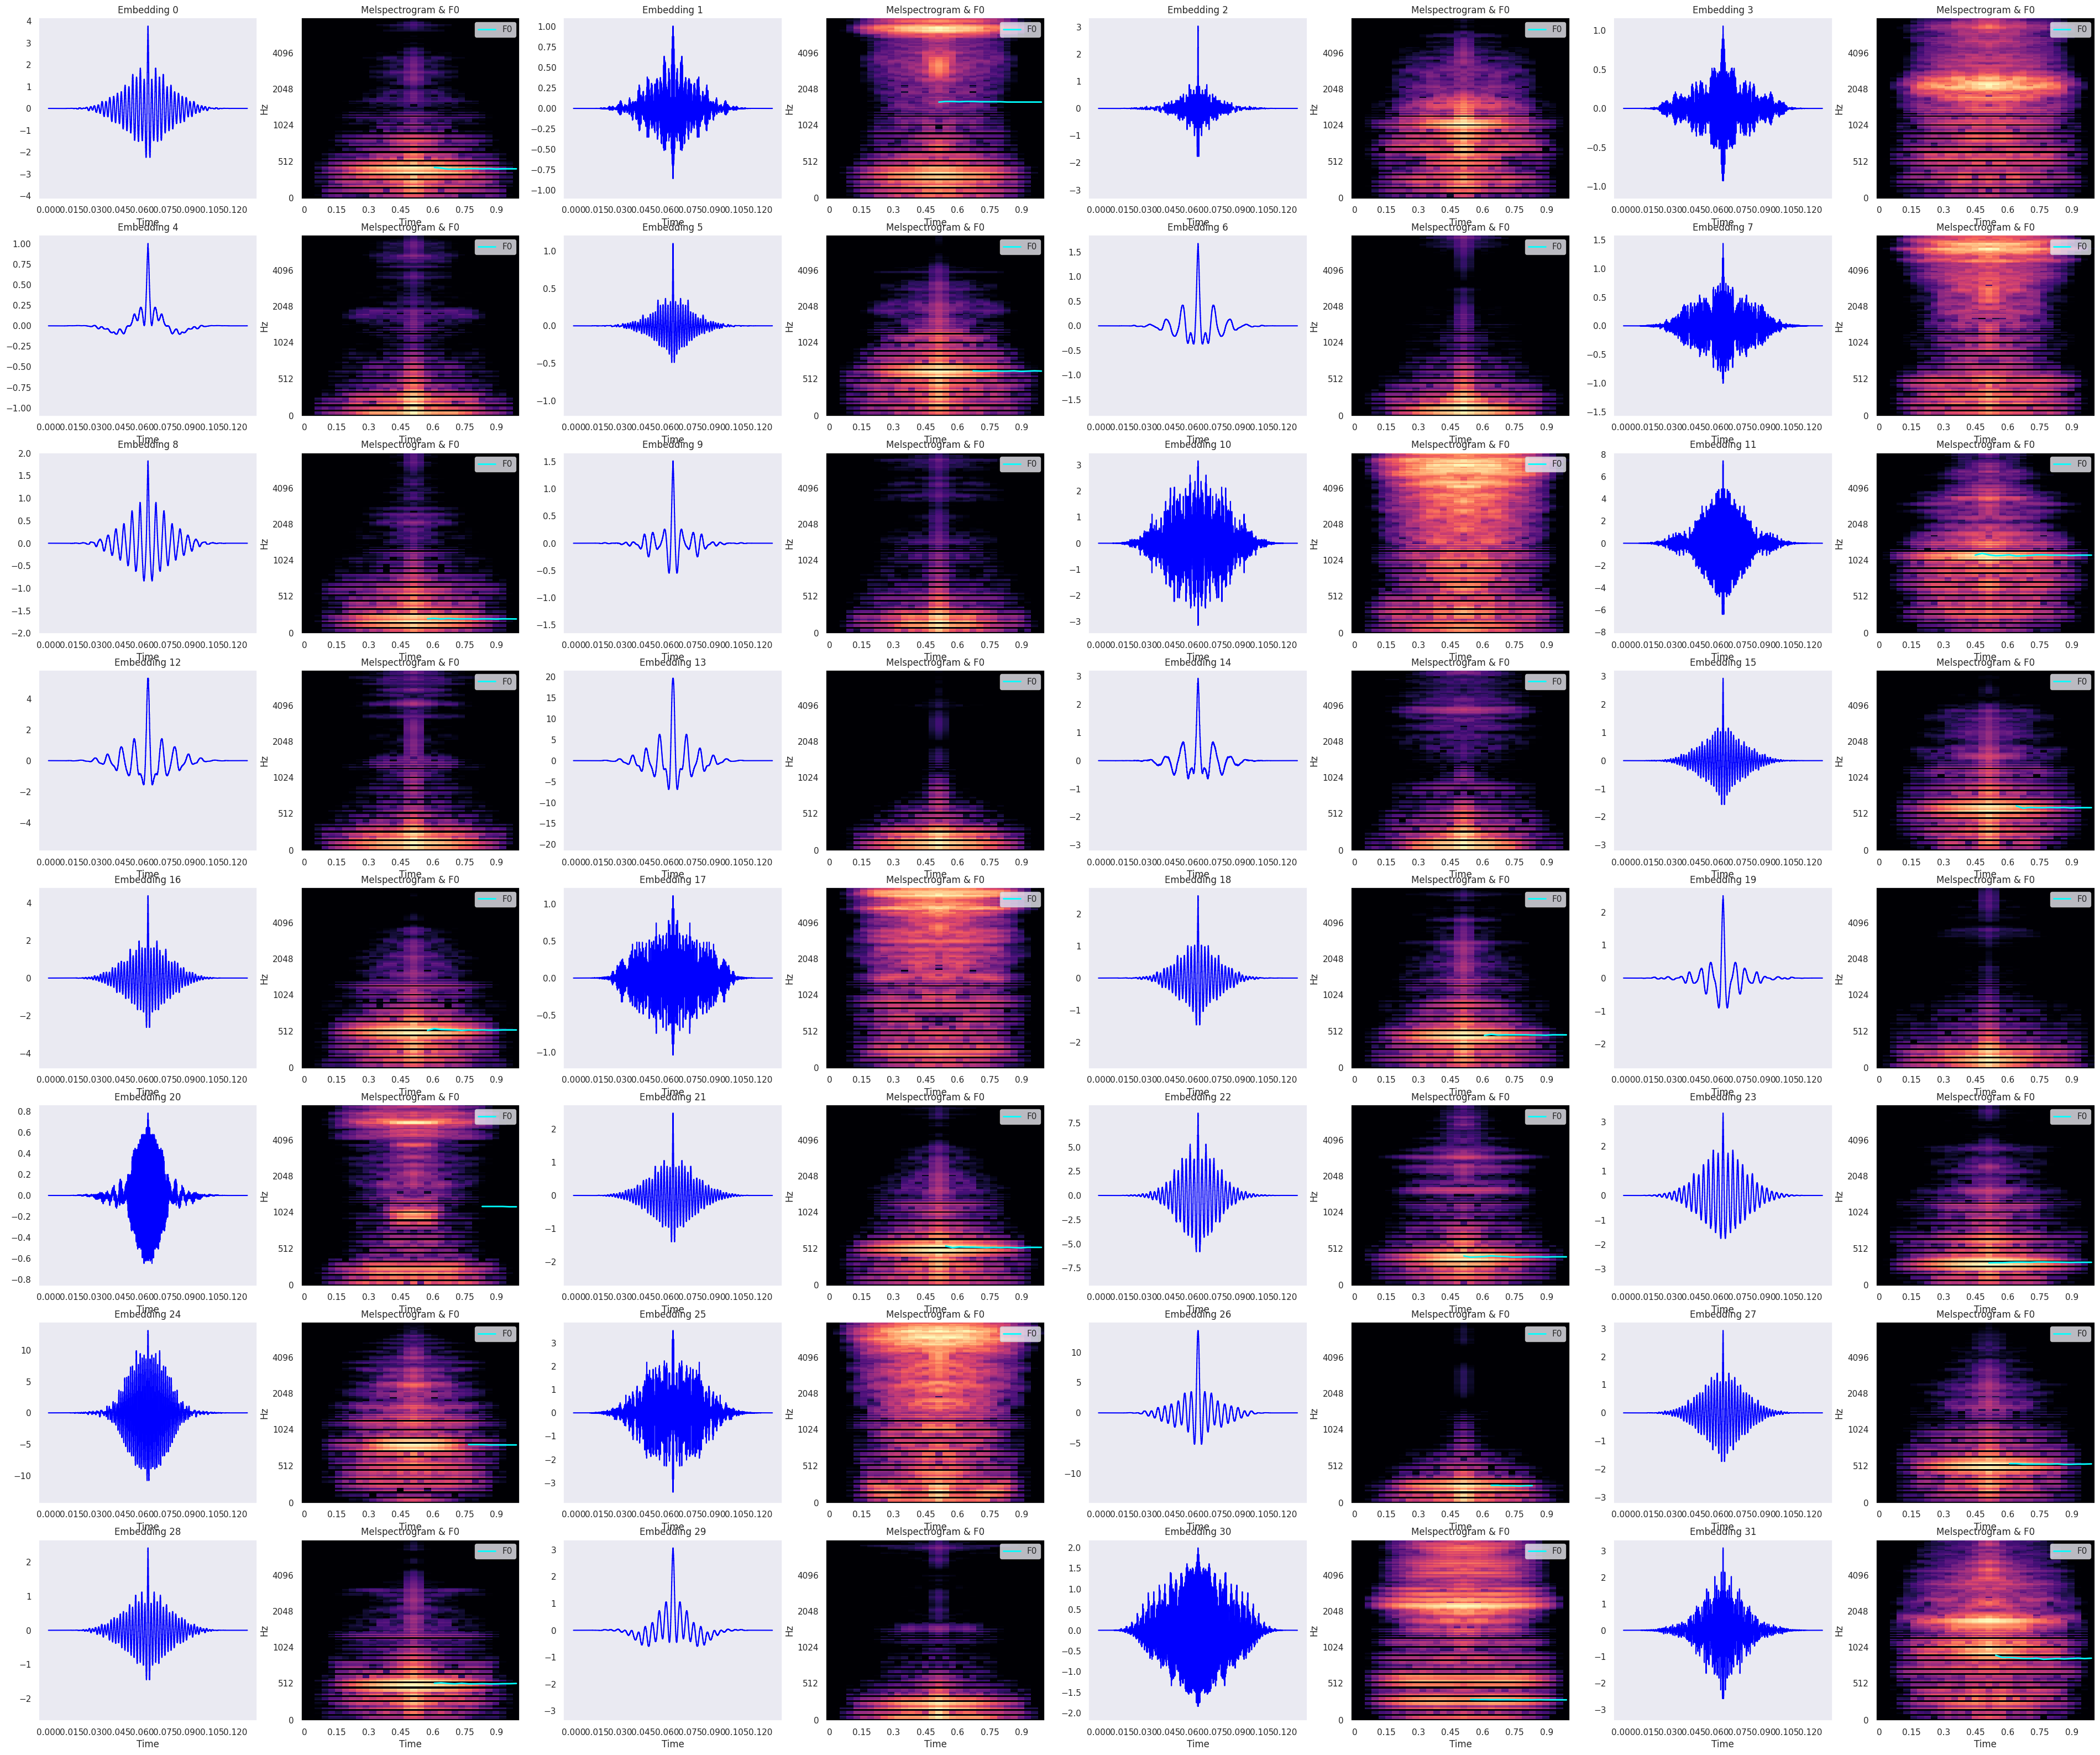

In [237]:
show_feature(emb_data2.numpy(), n=64)

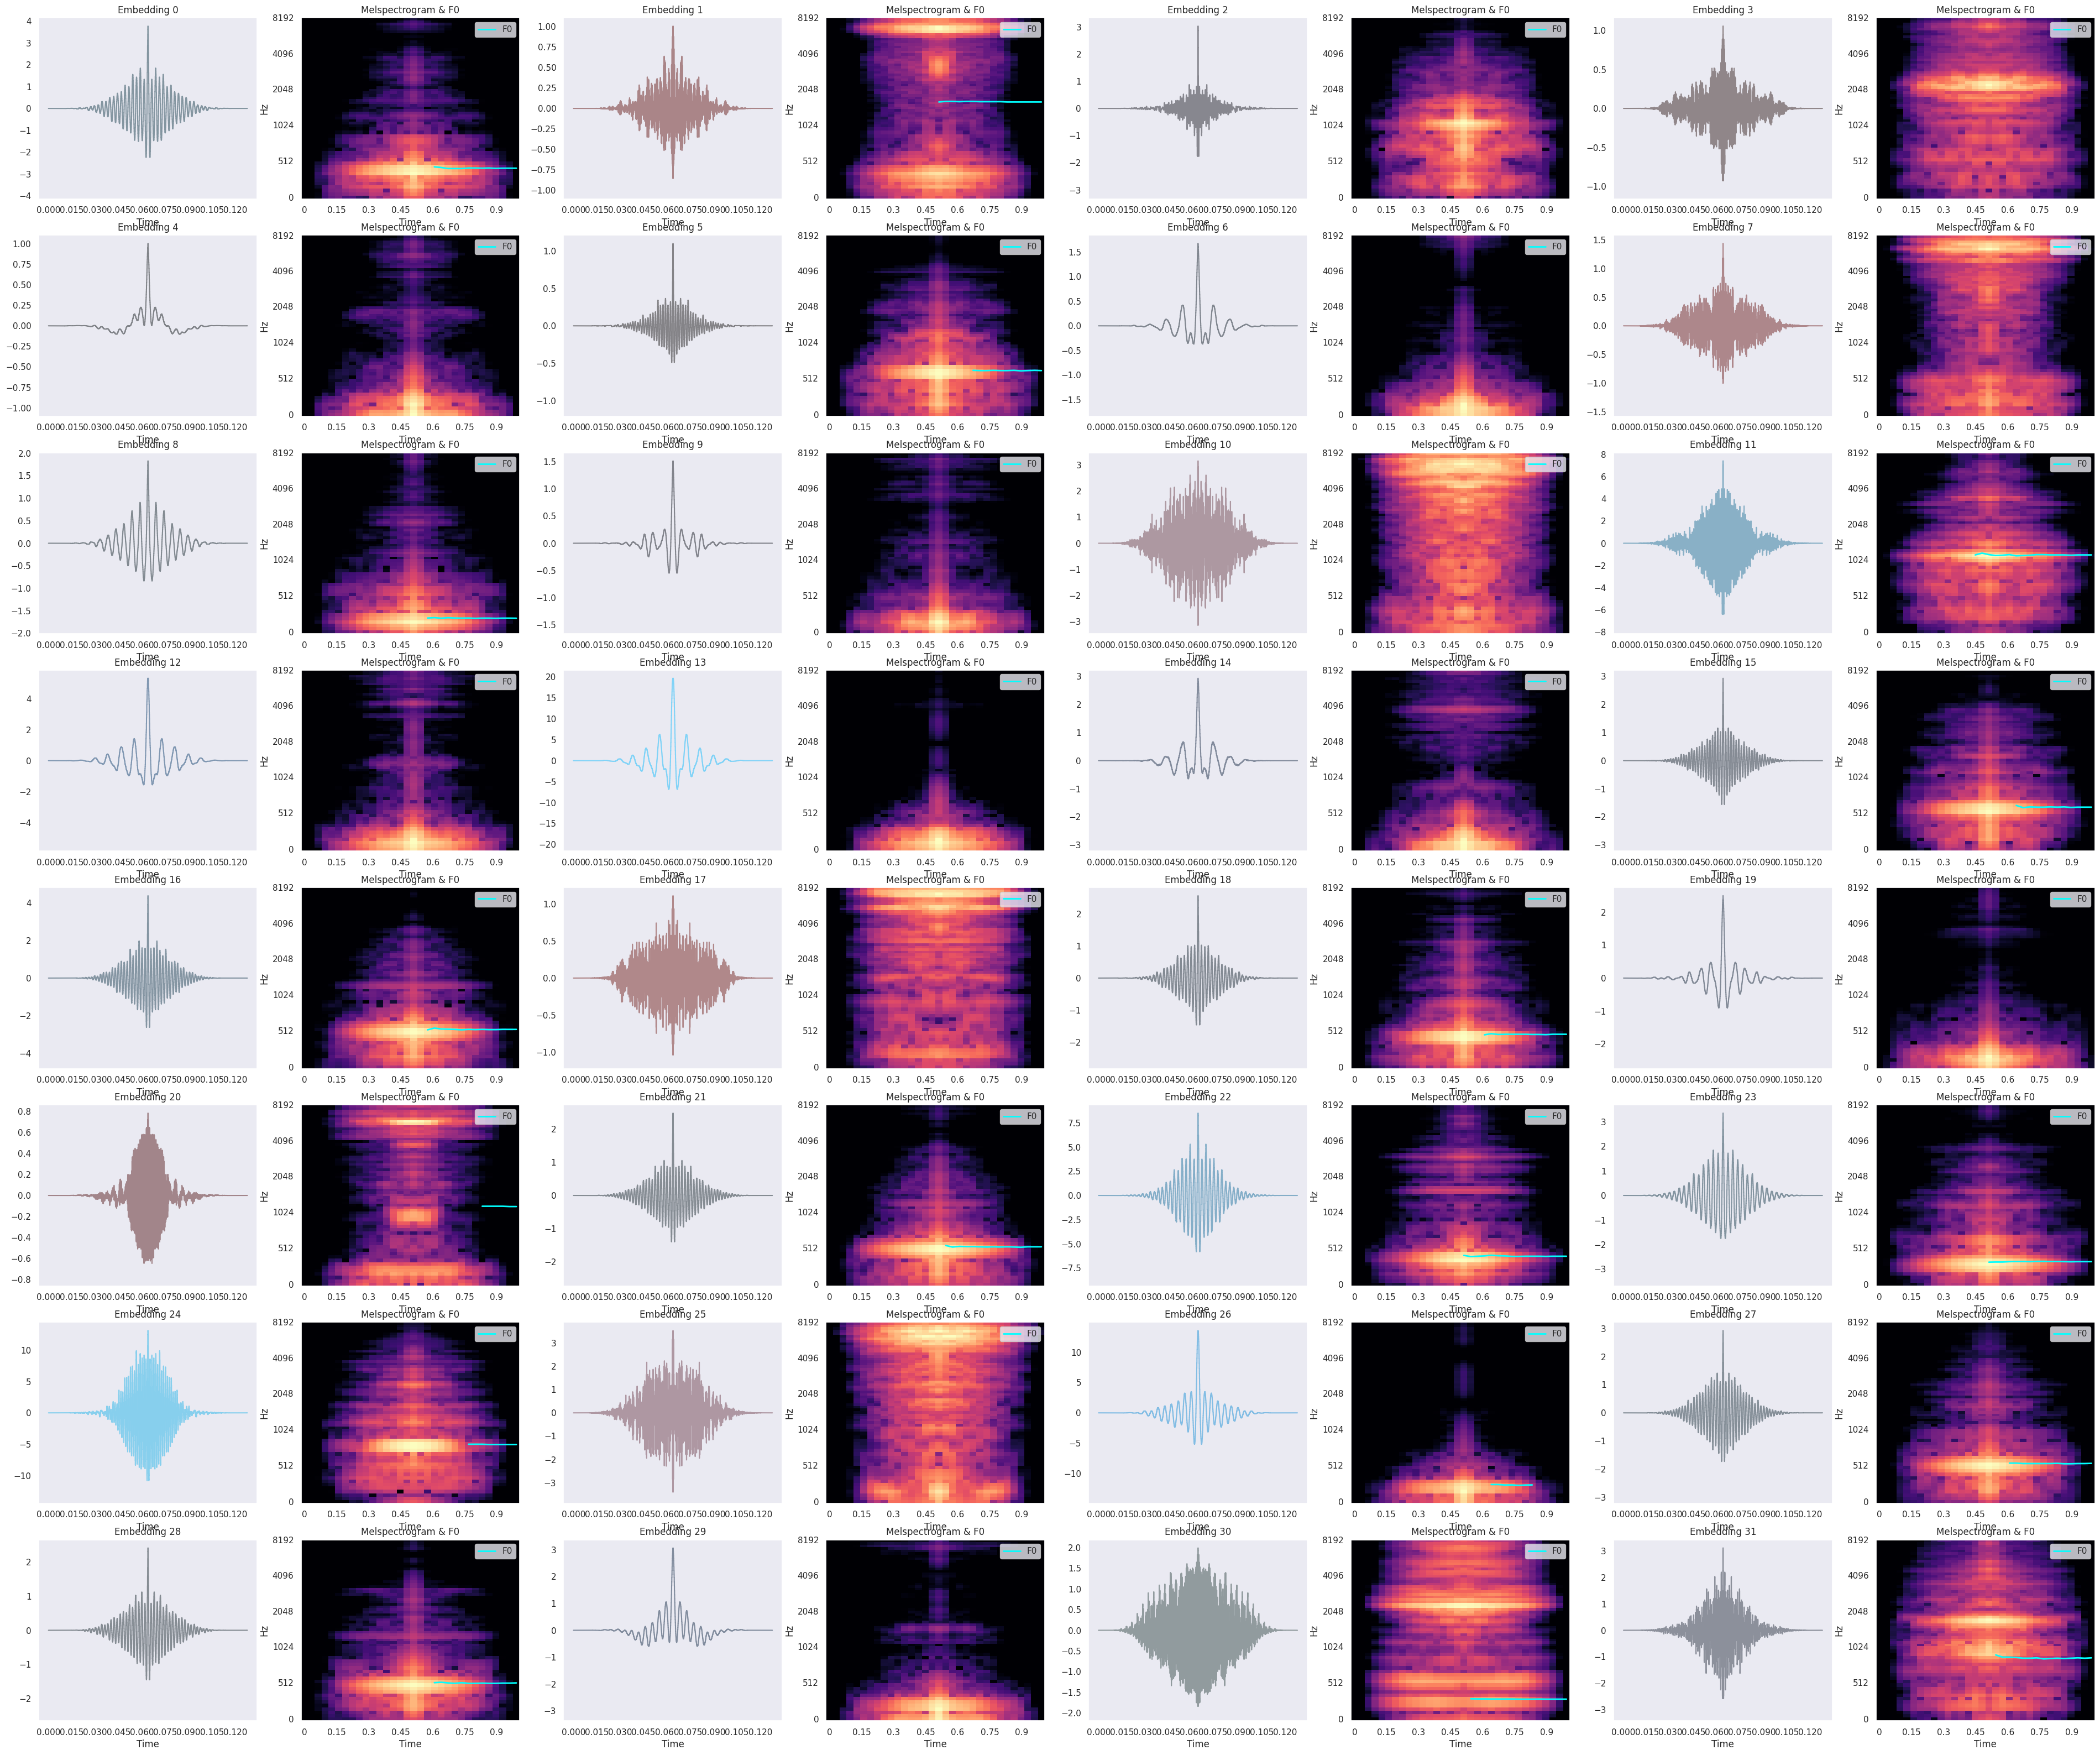

In [243]:
show_feature(emb_data2.numpy(), n=64, colors=colors_sig)

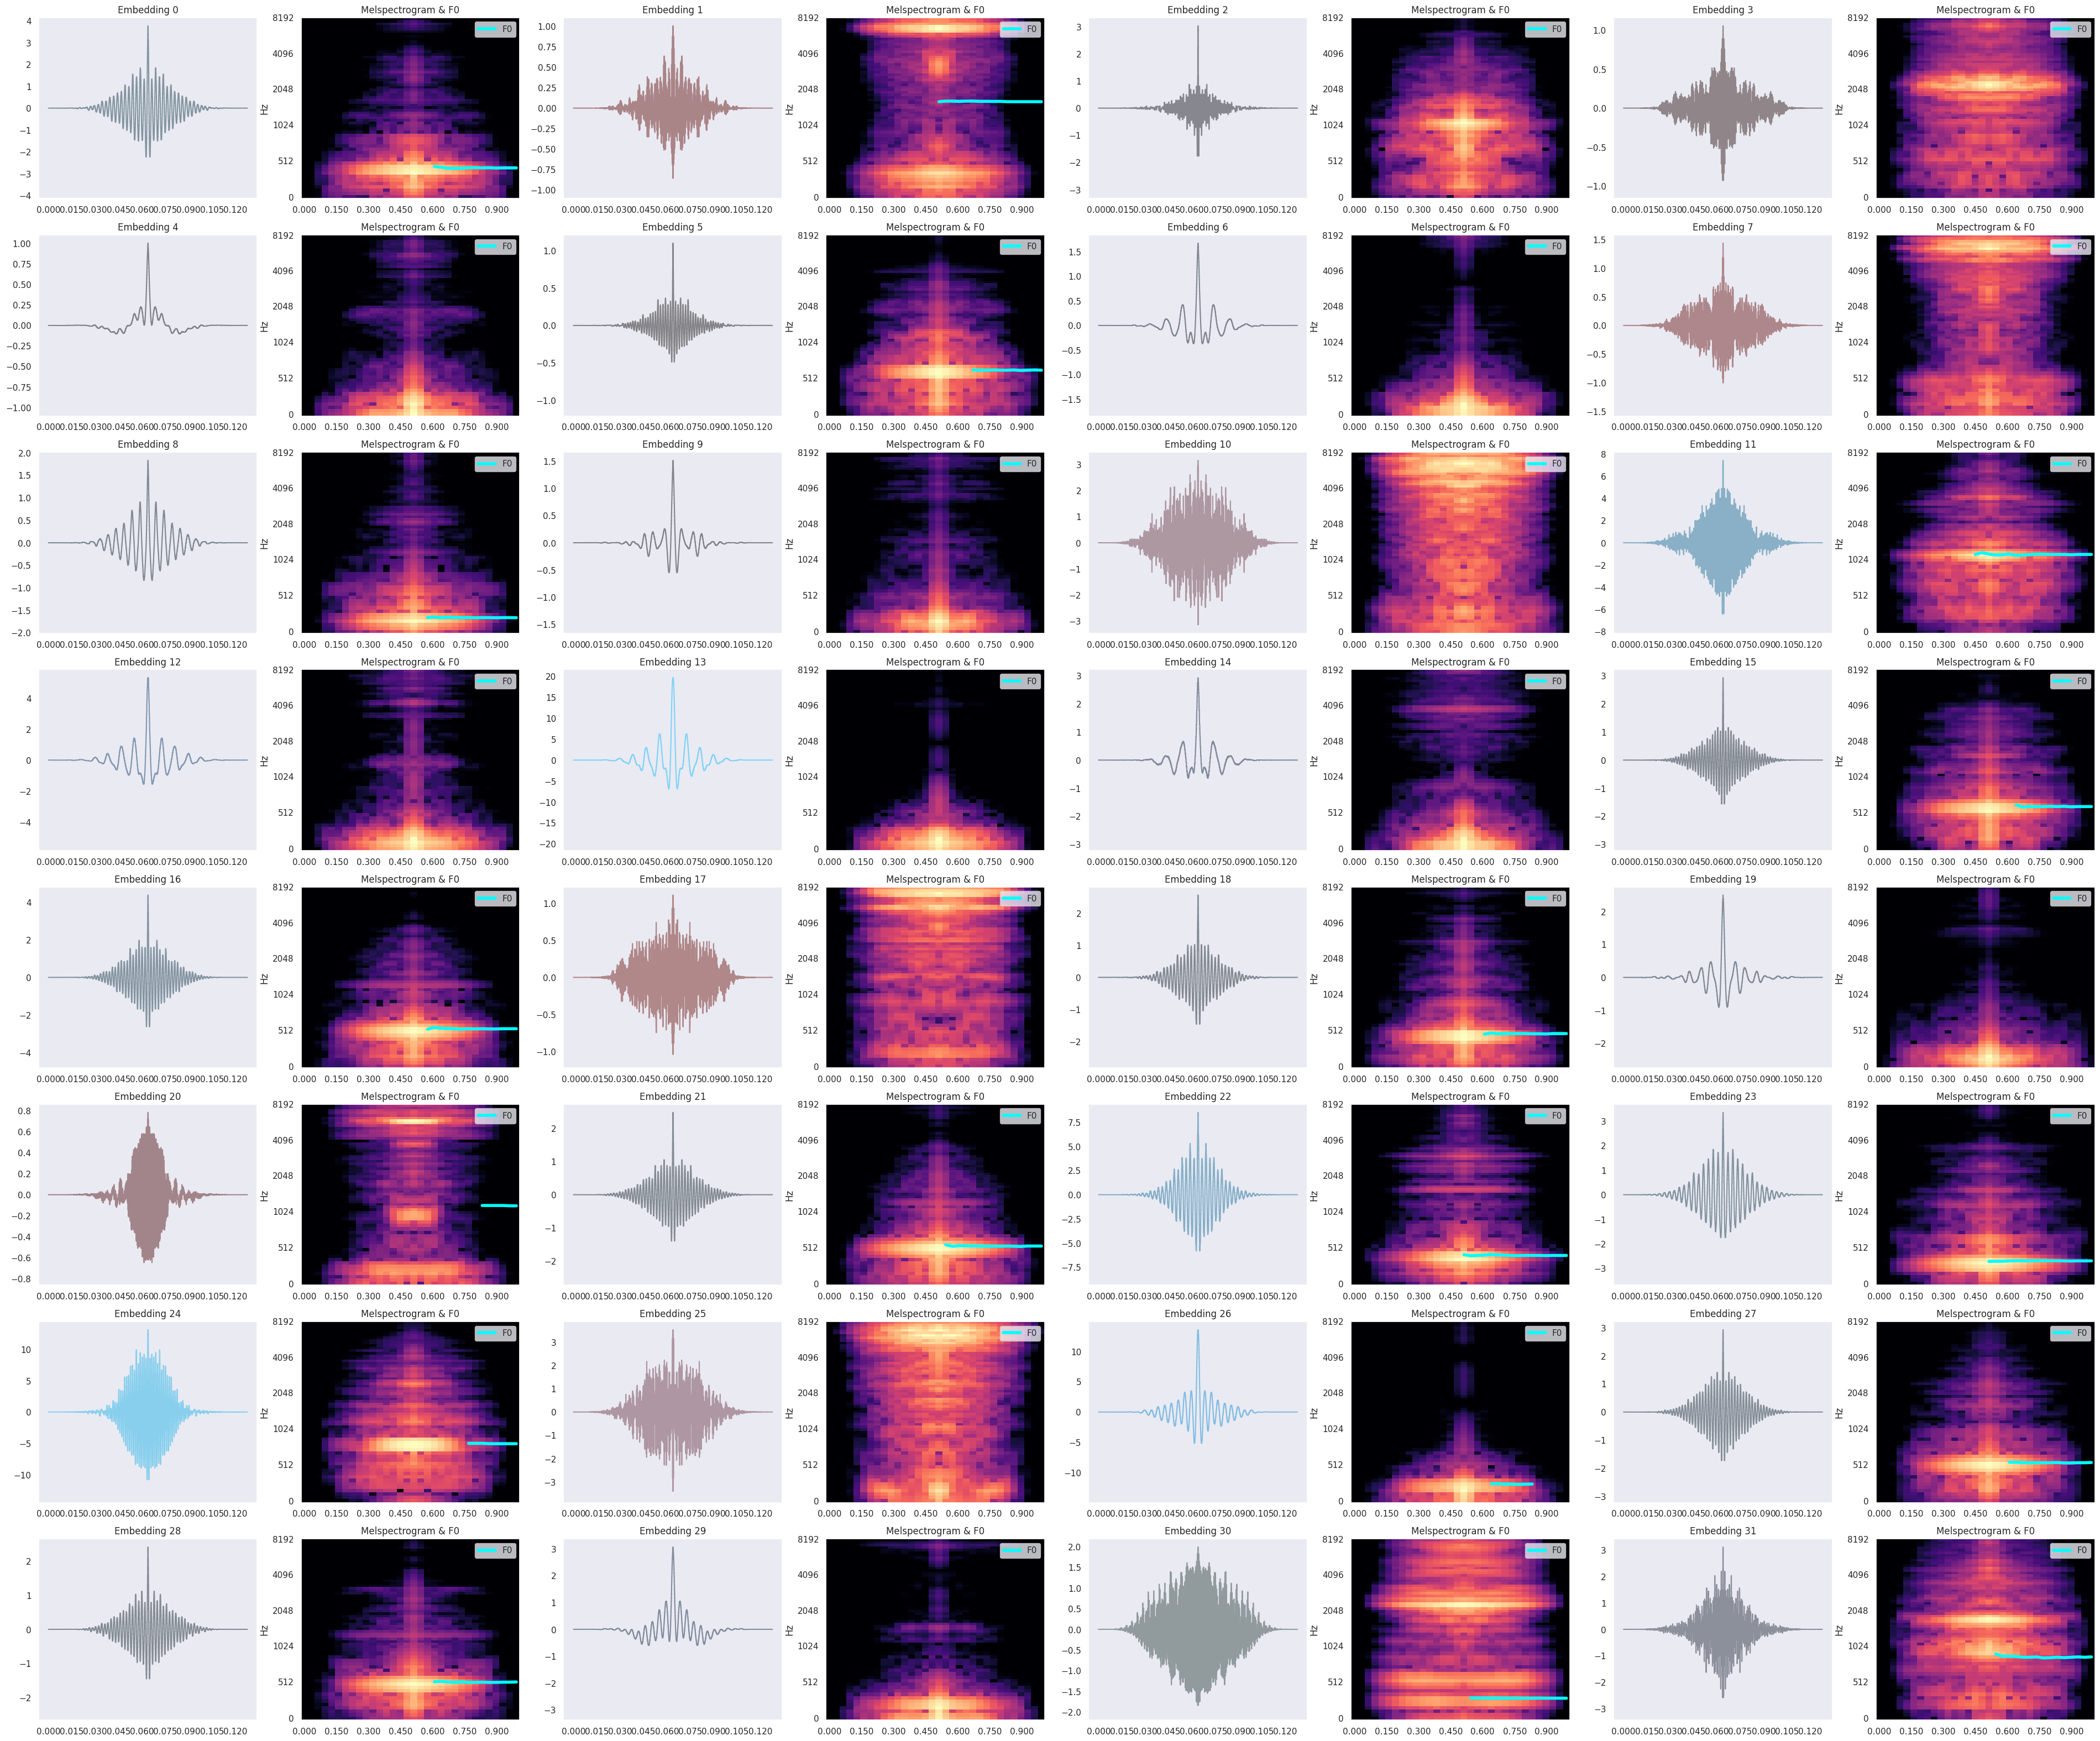

In [246]:
show_feature(emb_data2.numpy(), n=64, colors=colors_sig)

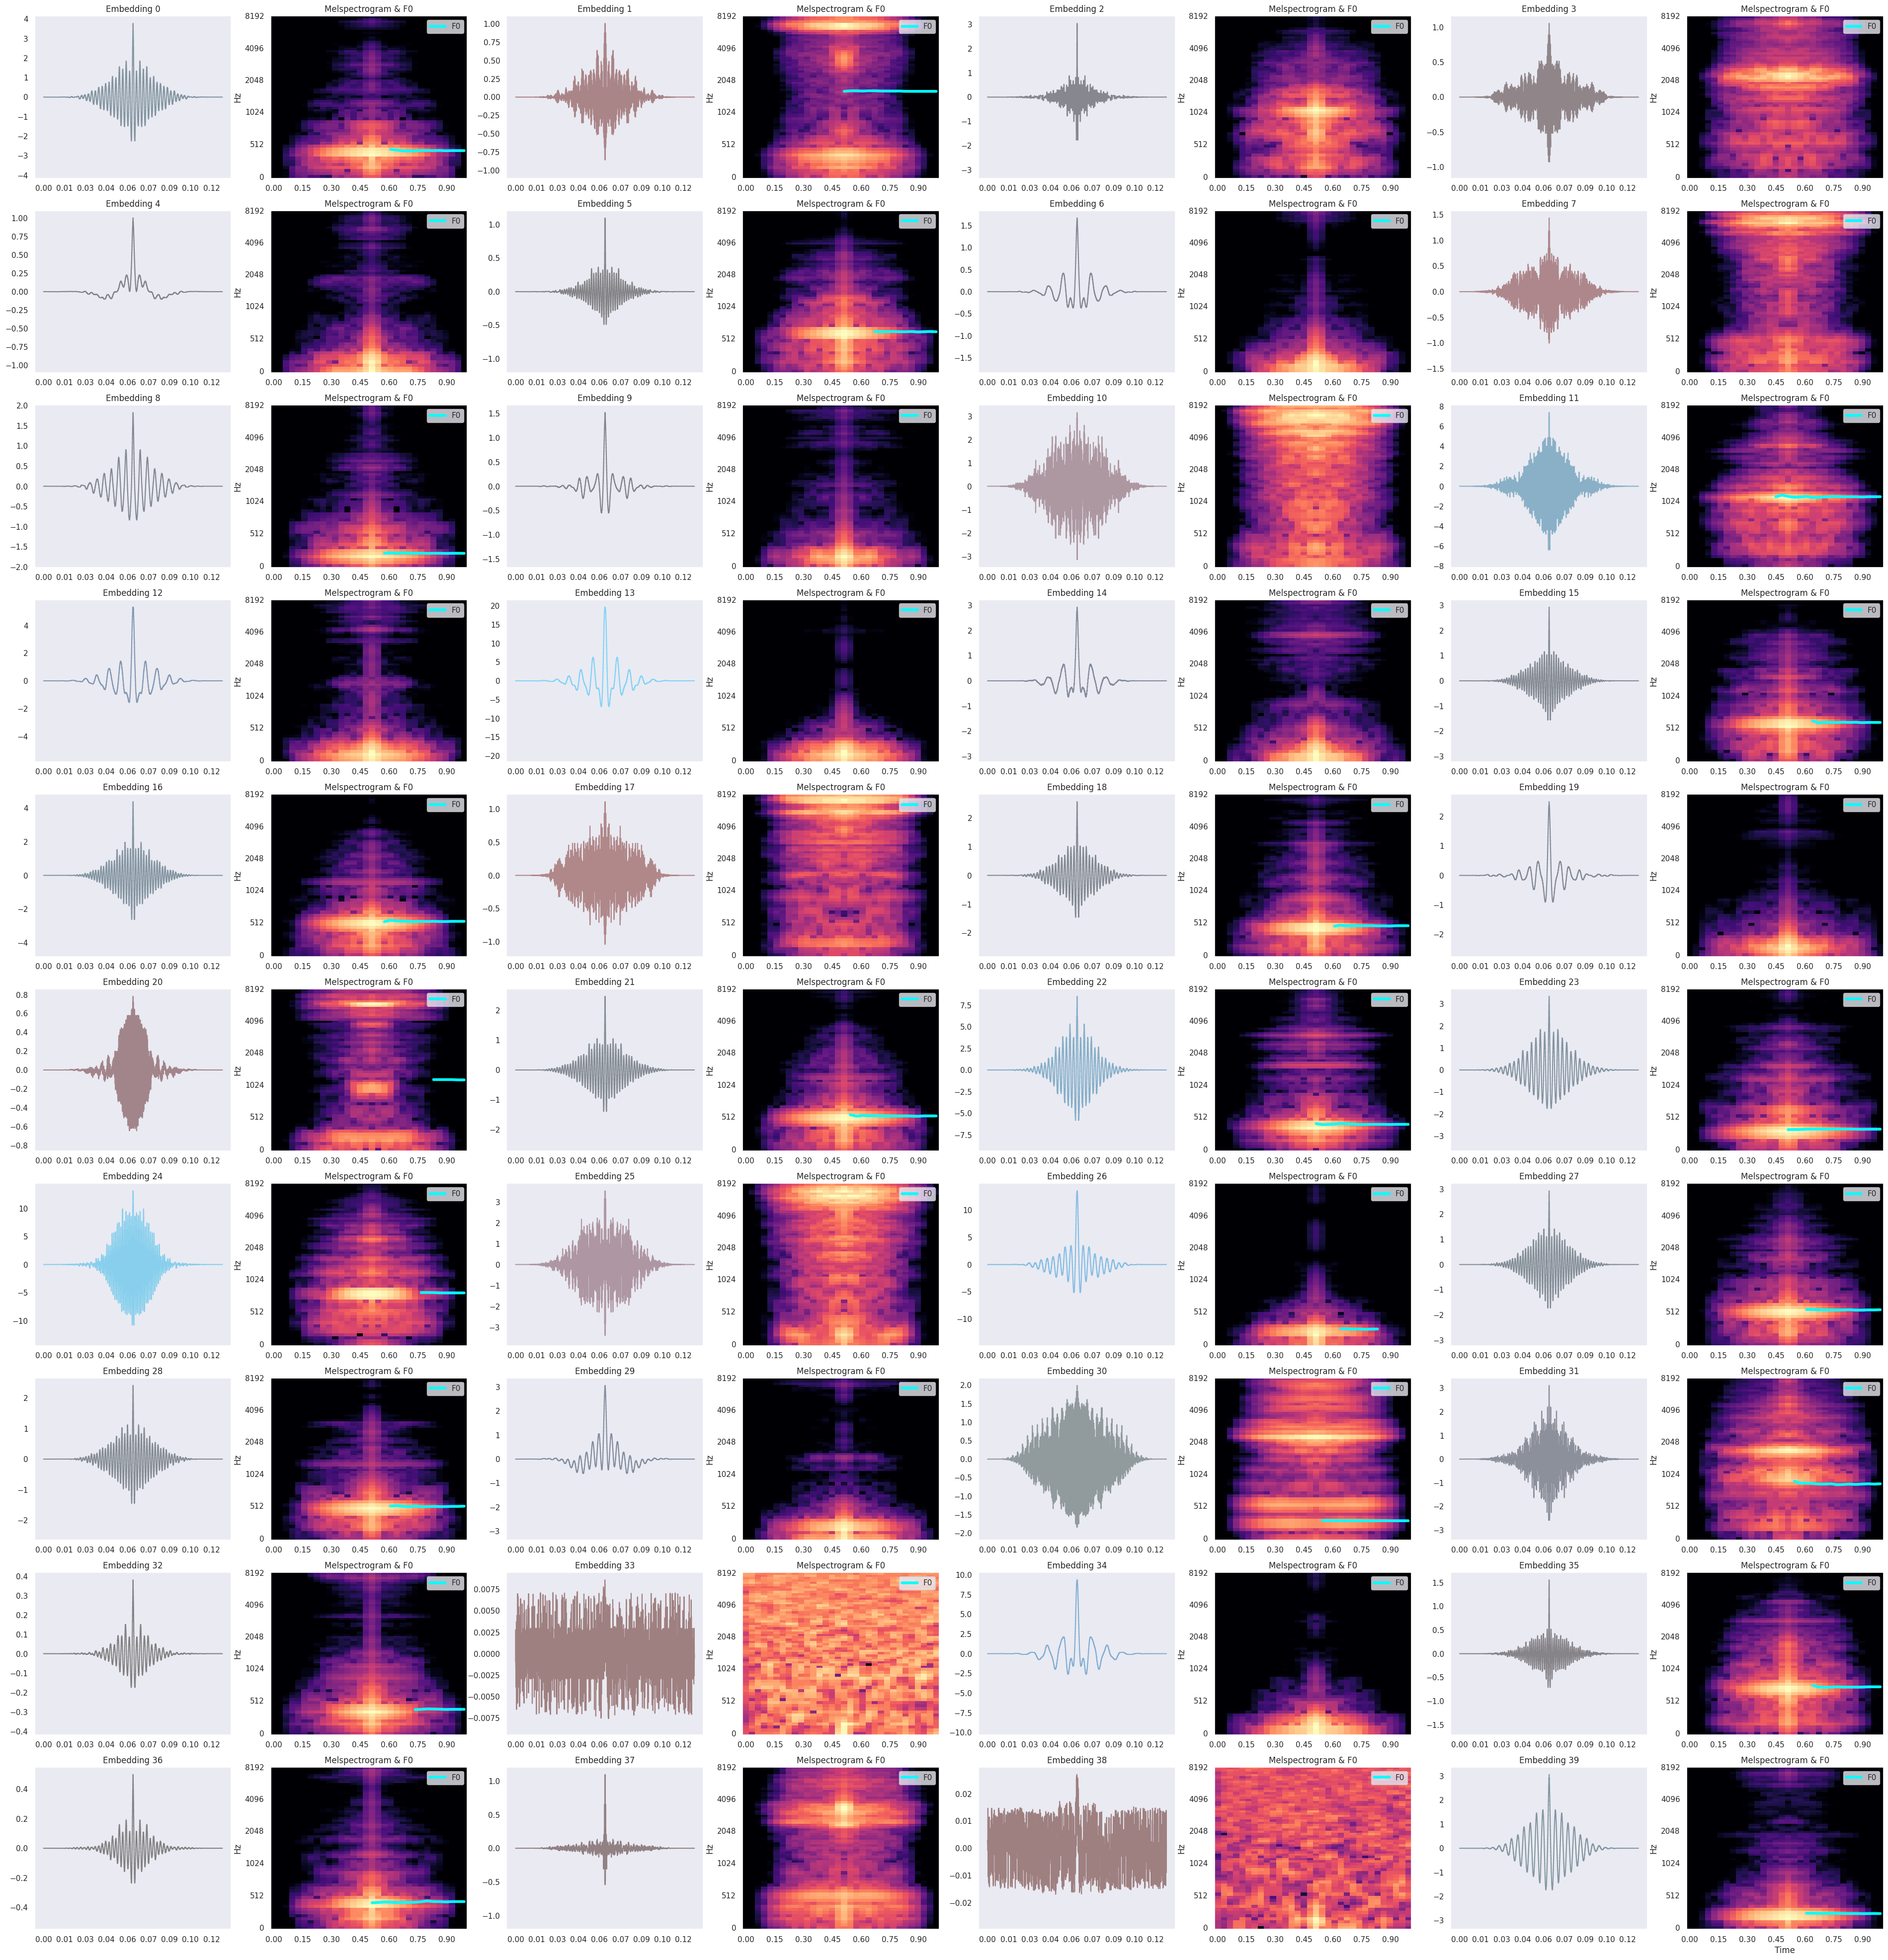

In [249]:
show_feature(emb_data2.numpy(), n=80, colors=colors_sig)